<a href="https://colab.research.google.com/github/Taram1980/finance_ML/blob/master/Copy_my_script_sycle(Santiment).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIP

In [1]:
! pip install NRCLex
! pip install transformers
! pip install pytorch_pretrained_bert
! pip install yfinance
! pip install alpha_vantage

     |████████████████████████████████| 399kB 8.4MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-cp37-none-any.whl size=43310 sha256=ac9f8d1ab796d715eb6e9e810bbbb1202232800a25cf174b7b291566c8adef0d
  Stored in directory: /root/.cache/pip/wheels/17/31/64/035a8d245b4c217aeb8e8a2702d05dc91544b9c2334db72414
Successfully built NRCLex
     |████████████████████████████████| 2.1MB 7.4MB/s 
     |████████████████████████████████| 890kB 36.5MB/s 
     |████████████████████████████████| 3.2MB 46.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=1a7bbe3d90b09de7295b82a545355b8a82abc6608f2c68682e6c97b9f278a2c0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 133kB 9.8MB/s 
     |████████████████████████████████| 133kB 16.3MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |█████████████████████████

# Check cuda:

In [2]:
import torch
display(torch.cuda.is_available())

True

# Library

In [3]:
import re
import requests
import unicodedata
from bs4 import BeautifulSoup
import requests
from nrclex import NRCLex
import pandas as pd
import pickle
# import yfinance as yf
import time
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
import numpy as np
from tqdm import tqdm
 
import bs4 as bs
import requests
import pandas as pd
 
from transformers import pipeline
import pandas as pd
from tqdm import tqdm
 
import sys
 
import nltk
nltk.download('punkt')
 
import os
import copy
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
# from bertModel import BertClassification, dense_opt
# from datasets import text_dataset, financialPhraseBankDataset
import argparse
from sklearn.metrics import f1_score
 
from transformers import pipeline

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

from statistics import mean

import matplotlib.pyplot as plt
import seaborn as sns


pd.options.mode.chained_assignment = None  # default='warn'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## DEL Library for finBert from dataset and bertModel

In [4]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertConfig

class BertClassification(nn.Module):
   
    def __init__(self, weight_path, num_labels=2, vocab="base-cased"):
        super(BertClassification, self).__init__()
        self.num_labels = num_labels
        self.vocab = vocab 
        if self.vocab == "base-cased":
            self.bert = BertModel.from_pretrained(weight_path)
            self.config = BertConfig(vocab_size_or_config_json_file=28996, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

        elif self.vocab == "base-uncased":
            self.bert = BertModel.from_pretrained(weight_path)
            self.config = BertConfig(vocab_size_or_config_json_file=30522, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)
            
        elif self.vocab == "finance-cased":
            self.bert = BertModel.from_pretrained(weight_path)
            self.config = BertConfig(vocab_size_or_config_json_file=28573, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

        elif self.vocab =="finance-uncased":
            self.bert = BertModel.from_pretrained(weight_path)
            self.config = BertConfig(vocab_size_or_config_json_file=30873, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
        nn.init.xavier_normal(self.classifier.weight)
    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None, graphEmbeddings=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)
       
        logits = self.classifier(pooled_output)
            
        return logits

class dense_opt():
    def __init__(self, model):
        super(dense_opt, self).__init__()
        self.lrlast = .001
        self.lrmain = .00001
        self.optim = optim.Adam(
        [ {"params":model.bert.parameters(),"lr": self.lrmain},
          {"params":model.classifier.parameters(), "lr": self.lrlast},
       ])
    
    def get_optim(self):
        return self.optim
import os 
import json 
import numpy as np 
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
import pandas as pd

class text_dataset(Dataset):
    def __init__(self, x_y_list, vocab_path, max_seq_length=256, vocab = 'base-cased', transform=None):
        self.max_seq_length = max_seq_length
        self.x_y_list = x_y_list
        self.vocab = vocab
        if self.vocab == 'base-cased':
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False, do_basic_tokenize=True)
        elif self.vocab == 'finance-cased':
            self.tokenizer = BertTokenizer(vocab_file = vocab_path, do_lower_case = False, do_basic_tokenize = True)
        elif self.vocab == 'base-uncased':
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, do_basic_tokenize=True) 
        elif self.vocab == 'finance-uncased':
            self.tokenizer = BertTokenizer(vocab_file = vocab_path, do_lower_case = True, do_basic_tokenize = True)
    
    def __getitem__(self,index):
        tokenized_review = self.tokenizer.tokenize(self.x_y_list[0][index])
        
        if len(tokenized_review) > self.max_seq_length:
            tokenized_review = tokenized_review[:self.max_seq_length]
            
        ids_review  = self.tokenizer.convert_tokens_to_ids(tokenized_review)
        
        mask_input = [1]*len(ids_review)
        
        padding = [0] * (self.max_seq_length - len(ids_review))
        ids_review += padding
        mask_input += padding
        
        input_type = [0]*self.max_seq_length  
        
        assert len(ids_review) == self.max_seq_length
        assert len(mask_input) == self.max_seq_length
        assert len(input_type) == self.max_seq_length 
        
        ids_review = torch.tensor(ids_review)
        mask_input =  torch.tensor(mask_input)
        input_type = torch.tensor(input_type)
        
        sentiment = self.x_y_list[1][index] 
        list_of_labels = [torch.from_numpy(np.array(sentiment))]
        
        input_feature = {"token_type_ids": input_type, "attention_mask":mask_input, "input_ids":ids_review}
        
        return input_feature, list_of_labels[0]
    
    def __len__(self):
        return len(self.x_y_list[0])


def transform_labels(x_y_list):
    dict_labels = {'positive': 0, 'neutral':1, 'negative':2}
    x_y_list_transformed = [[item[0], dict_labels[item[1]]] for item in x_y_list]
    X = np.asarray([item[0] for item in x_y_list_transformed])
    y = np.asarray([item[1] for item in x_y_list_transformed])
    return X, y

def financialPhraseBankDataset(dir_):
    fb_path = os.path.join(dir_, 'FinancialPhraseBank-v1.0')
    data_50 = os.path.join(fb_path, 'Sentences_50Agree.txt')
    sent_50 = []
    rand_idx = 45
    
    with open(data_50, 'rb') as fi:
        for l in fi:
            l = l.decode('utf-8', 'replace')
            sent_50.append(l.strip())
    
    x_y_list_50 = [sent.split("@") for sent in sent_50]
    x50, y50 = transform_labels(x_y_list_50)
    
    data = [x50, y50]
    X_train, X_test, y_train, y_test = train_test_split(data[0], data[1], test_size=0.1, random_state=rand_idx, stratify=data[1])

    y_train = pd.get_dummies(y_train).values.tolist()
    y_test = pd.get_dummies(y_test).values.tolist()
    X_train = X_train.tolist()
    X_test = X_test.tolist()
            
    final_data = [X_train, X_test, y_train, y_test] 
     
    return final_data

## Library McDonald

In [5]:
def load_finphrase(filename):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    df = pd.read_csv(finphrase_dir + filename,
                     sep='\@',
                     engine='python',
                     encoding='latin-1',
                     header=None,
                     names=['sentence','label'])
    print('Total number of record in the file: ', df.shape[0])
    df.drop_duplicates(inplace=True)
    print('Total number of record after dropping duplicates: ', df.shape[0])
    print('Missing label: ', df['label'].isnull().sum())
    df.reset_index(inplace=True, drop=True)
    # df = pd.get_dummies(df, columns=['label'])
    return df


# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    # results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
    results = [tone_score]
    return results

# columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']
columns = ['tone_score']

## my_Defs for finBert

In [6]:
def bert(sentences):
  l_all = []
  p_all = []
  model.eval()
  for sent in (sentences): 
      tokenized_sent = tokenizer.tokenize(sent)
      label = []
      perse = []
      if len(tokenized_sent) > max_seq_length:
          tokenized_sent = tokenized_sent[:max_seq_length]
      
      ids_review  = tokenizer.convert_tokens_to_ids(tokenized_sent)
      mask_input = [1]*len(ids_review)        
      padding = [0] * (max_seq_length - len(ids_review))
      ids_review += padding
      mask_input += padding
      input_type = [0]*max_seq_length
      
      input_ids      = torch.tensor(ids_review).to(device).reshape(-1, 256)
      attention_mask = torch.tensor(mask_input).to(device).reshape(-1, 256)
      token_type_ids = torch.tensor(input_type).to(device).reshape(-1, 256)
      
      with torch.set_grad_enabled(False):
          outputs = model(input_ids, token_type_ids, attention_mask)
          outputs = F.softmax(outputs,dim=1)
          # print(sent, '\nFinBERT predicted sentiment: ', labels[torch.argmax(outputs).item()], '\n', outputs.max(0)[0].max(), '\n')
          label.append(labels[torch.argmax(outputs).item()])
          perse.append(outputs.max(0)[0].max())

      l_all.append(label)
      p_all.append(perse)    
  return l_all, p_all

def Average(lst):
    return mean(lst)

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Mount GDrive and my_dir


In [8]:
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  my_dir = '/content/drive/MyDrive/Marat/'
  my_dir_yuki = '/content/drive/MyDrive/Yuki/financial-phrase-bert-master/'
  finphrase_dir = my_dir_yuki + 'FinancialPhraseBank-v1.0/'
  lmdict_dir = my_dir_yuki + '/LoughranMcDonald/'
else:
  my_dir = u'F:/Мой диск/Marat/'

Mounted at /content/drive


# Usefull utility

## Структура document

In [ ]:
display(document.keys())
# display(document['MMM'].keys())
display(document['MMM']['10Q'].keys())
display(document['MMM']['10Q']['2019-10-25'].keys())
display(document['MMM']['10Q']['2019-10-25']['len_2item'])
display(document['MMM']['10Q']['2019-10-25']['numb_aff'])
# display(document['MMM']['2019-02-07']['len_ex_7'])
# display(document['MMM']['2019-02-07']['expect_7'])

dict_keys(['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BK', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'BIIB', 'BLK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BF.B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CTVA', 'COST', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'D

dict_keys(['2020-10-27', '2020-07-28', '2020-04-28', '2019-10-25', '2019-07-26', '2019-04-26', '2018-10-25', '2018-07-26', '2018-05-08', '2017-10-31', '2017-08-01', '2017-05-03', '2016-11-01', '2016-08-02', '2016-05-03', '2015-10-29', '2015-07-30', '2015-04-30', '2014-10-30', '2014-07-31', '2014-05-01', '2013-10-31', '2013-08-01', '2013-05-02', '2012-11-01', '2012-08-02', '2012-05-03', '2011-11-03', '2011-08-04', '2011-05-05', '2010-11-05', '2010-08-04', '2010-05-05', '2009-10-30', '2009-07-31', '2009-05-01', '2008-10-31', '2008-08-01', '2008-05-02', '2007-10-29'])

dict_keys(['item_2_raw', 'affect', 'len_2item', 'numb_aff'])

89578

0.1957785255429795

In [ ]:
n0 = 0
n1 = 0
n2 = 0
n3 = 0
n4 = 0
n5 = 0
n6 = 0
n7 = 0
n8 = 0
s = 0

for i in document.keys():
  for ii in document[i]['10Q'].keys():
    s+=1
    # display(document[i][ii].keys())
    if len(document[i]['10Q'][ii].keys()) == 0:
      n0+=1
    elif len(document[i]['10Q'][ii].keys()) == 1:
      n1+=1
    elif len(document[i]['10Q'][ii].keys()) == 2:
      n2+=1
    elif len(document[i]['10Q'][ii].keys()) == 3:
      n3+=1
    elif len(document[i]['10Q'][ii].keys()) == 4:
      n4+=1
    elif len(document[i]['10Q'][ii].keys()) >= 5:
      n5+=1  
    # elif len(document[i][ii].keys()) == 6:
    #   n6+=1
    # elif len(document[i][ii].keys()) == 7:
    #   n7+=1
    # elif len(document[i][ii].keys()) == 8:
    #   n8+=1


display(n0, n1, n2, n3, n4, n5, n6, n7, n8, s)

0

6314

0

0

12270

0

0

0

0

18584

# CIK_Lookup


In [9]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

tickers = []
industries = []
sectors = []

for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        industry = row.findAll('td')[7].text
        sector = row.findAll('td')[3].text

        tickers.append(ticker)
        industries.append(industry)
        sectors.append(sector)

tickers    = list(map(lambda s: s.strip(), tickers))
industries = list(map(lambda s: s.strip(), industries))
sectors     = list(map(lambda s: s.strip(), sectors))

tickerdf = pd.DataFrame(tickers,columns=['ticker'])
sectordf = pd.DataFrame(industries,columns=['SEC'])
sector2df = pd.DataFrame(sectors,columns=['industry'])

tickerandsector = pd.concat([tickerdf, sectordf, sector2df], axis=1)

cik_lookup = dict(tickerandsector[['ticker', 'SEC']].values)

In [10]:
# cut cik_lookup

# n = 0
# a = []
# b = []

# for k, v in cik_lookup.items():
#   if n < 5:
#     a.append(k)
#     b.append(v)
#     n+=1
#     display(n)
#   else:
#     break

# cik_lookup = {a1:b1 for a1, b1 in zip(a,b)}
# cik_lookup

# Качаем котировки

In [11]:
%%time
ts = TimeSeries(key='you code', output_format='pandas')
stock = pd.DataFrame()
# for ticker in list(cik_lookup.keys())[496:]:    ### ДОКАЧАТЬ
for ticker in ['AAPL', 'AMZN', 'FB', 'GOOGL', 'NFLX']:
    time.sleep(10)
#     try:
    display(ticker)
    s1, meta_data = ts.get_daily_adjusted(symbol=ticker, outputsize='full')
    # s1 = s1[['5. adjusted close']]
    s1['Symbol'] = ticker
    s1['Date'] = s1.index
    s1 = s1.drop_duplicates('Date')
    s1 = s1.sort_index()
    # for ii in range(50, 350, 100):
    #     s1[str(ii) + '_%'] = (s1['5. adjusted close'].shift(-ii)/s1['5. adjusted close'] - 1)*100 

    stock = stock.append(s1)
#     except:
#         continue
# stock

'AAPL'

'AMZN'

'FB'

'GOOGL'

'NFLX'

CPU times: user 255 ms, sys: 24.4 ms, total: 279 ms
Wall time: 59.6 s


In [14]:
stock.to_csv('/content/drive/MyDrive/Marat/stock_for_Byes.csv')

In [ ]:
# new_ = pd.DataFrame()
# for i in stock['Symbol'].unique():
# # for i in ['TSN', 'WAT']:
# #     display(i)
#     s1 = stock[stock['Symbol'] == i]
#     for ii in range(50, 350, 100):
#         s1[str(ii) + '_%'] = (s1['5. adjusted close'].shift(-ii)/s1['5. adjusted close'] - 1)*100 
#     new_ = new_.append(s1)
    

# Сбор 10-k

In [ ]:
# display(document.keys())
# display(document['AMZN'].keys())
# display(document['AMZN']['2019-02-01'].keys())
# display((document['AMZN']['2019-02-01']['affect_frequencies']))

In [ ]:
%%time

def restore_windows_1252_characters(restore_string):
    """
        Replace C1 control characters in the Unicode string s by the
        characters at the corresponding code points in Windows-1252,
        where possible.
    """

    def to_windows_1252(match):
        try:
            return bytes([ord(match.group(0))]).decode('windows-1252')
        except UnicodeDecodeError:
            # No character at the corresponding code point: remove it.
            return ''
        
    return re.sub(r'[\u0080-\u0099]', to_windows_1252, restore_string)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


## Список ссылок к SEC

In [ ]:
%%time

#создать 1 раз и не перезаписывать
htm_list = {} 
text_object_dic = {} # поднять навез чтобы не перезаписывать


# base URL for the SEC EDGAR browser
endpoint = r"https://www.sec.gov/cgi-bin/browse-edgar"
# CIK = '0001018724'
# define our parameters dictionary
for CIK in tqdm(cik_lookup.values()):
# for CIK in list(cik_lookup.values())[100:120]:
    # display(CIK)
    param_dict = {'action':'getcompany',
                  'CIK':CIK,
                  'type':'10-K',
                  'dateb':'20210101',
                  'owner':'exclude',
                  'start':'',
                  'output':'',
                  'count':'10'}
    # request the url, and then parse the response.
    response = requests.get(url = endpoint, params = param_dict)
    # display('here')
    if response.status_code == 429:
      time.sleep(int(response.headers["Retry-After"]))
    else:
      soup = BeautifulSoup(response.content, 'html.parser')
      
      # Let the user know it was successful.
      # print('Request Successful')
      # print(response.url)

      doc_table = soup.find_all('table', class_='tableFile2')

      # define a base url that will be used for link building.
      base_url_sec = r"https://www.sec.gov"

      master_list = []
      filing_doc_links = []
      
      # loop through each row in the table.
      for row in doc_table[0].find_all('tr')[1:]:
          # display('here')
          # find all the columns
          cols = row.find_all('td')

          # if there are no columns move on to the next row.
          if len(cols) != 0:        

              # grab the text
              filing_type = cols[0].text.strip()                 
              filing_date = cols[3].text.strip()
              filing_numb = cols[4].text.strip()

              # find the links
              filing_doc_href = cols[1].find('a', {'href':True, 'id':'documentsbutton'})       
              filing_int_href = cols[1].find('a', {'href':True, 'id':'interactiveDataBtn'})
              filing_num_href = cols[4].find('a')

              # grab the the first href
              if filing_doc_href != None:
                  filing_doc_link = base_url_sec + filing_doc_href['href'] 
              else:
                  filing_doc_link = 'no link'

              # grab the second href
              if filing_int_href != None:
                  filing_int_link = base_url_sec + filing_int_href['href'] 
              else:
                  filing_int_link = 'no link'

              # grab the third href
              if filing_num_href != None:
                  filing_num_link = base_url_sec + filing_num_href['href'] 
              else:
                  filing_num_link = 'no link'

              # create and store data in the dictionary
              file_dict = {}
              file_dict['file_type'] = filing_type
              file_dict['file_number'] = filing_numb
              file_dict['file_date'] = filing_date
              file_dict['links'] = {}
              file_dict['links']['documents'] = filing_doc_link
              file_dict['links']['interactive_data'] = filing_int_link
              file_dict['links']['filing_number'] = filing_num_link

              # let the user know it's working
      #         print('-'*100)        
      #         print("Filing Type: " + filing_type)
      #         print("Filing Date: " + filing_date)
      #         print("Filing Number: " + filing_numb)
      #         print("Document Link: " + filing_doc_link)
      #         print("Filing Number Link: " + filing_num_link)
      #         print("Interactive Data Link: " + filing_int_link)

              # append dictionary to master list
              master_list.append(file_dict)
              filing_doc_links.append(filing_doc_link)


      finals_list = []
      data = []

      # МОЯ ДОБАВКА. ВТОРОЙ ТАБЛИЦА ВСЕ ВЗЯТЬ И ПОУЛЧИТЬ ДОКУМЕНТЫ
      for i in range(len(master_list)):
          response1 = requests.get(url = master_list[i]['links']['documents'])
          if response1.status_code == 429:
            time.sleep(int(response.headers["Retry-After"]))
          else:
          # https://www.sec.gov/Archives/edgar/data/1265107/000126510719000004/0001265107-19-000004-index.htm
            soup1 = BeautifulSoup(response1.content, 'html.parser')
            doc_table1 = soup1.find_all('table', class_='tableFile')

        #     filing_doc_href1 = doc_table1[0].find_all('a', {'href':True})[-1] #for txt
            filing_doc_href1 = doc_table1[0].find_all('a', {'href':True})[0] #for hml
            finals_list.append(base_url_sec + filing_doc_href1['href'])
            data.append(master_list[i]['file_date'])
      finals_list

      # СОЗДАЛИ СЛОВАРЬ С УКАЗАНИЕМ НА КОМПАНИЮ
      htm_list[CIK] = [finals_list,data]
  #     htm_list[CIK]


100%|██████████| 505/505 [08:52<00:00,  1.05s/it]

CPU times: user 2min 32s, sys: 4.49 s, total: 2min 36s
Wall time: 8min 52s


# Качаем htm_list

In [ ]:
# pickle.dump(htm_list, open(my_dir + "htm_list_colab.p", "wb"))
htm_list = pickle.load (open(my_dir + "htm_list_colab.p", "rb"))
# htm_list = pickle.load (open(my_dir + "htm_list_10Q_colab.p", "rb"))   # 10Q

# Pars re

In [ ]:
%%time



all = 0
all300 = 0
all50 = 0
all2 = 0
n = 0
# document = {}

for compony, CIK in tqdm(cik_lookup.items()):
# for compony, CIK in tqdm([list(cik_lookup.items())[1]):
    document[compony]['10Q'] = {}
    # display(compony,CIK)
    # document[compony] = {}        
    
    try:
        for item in range(0, len(htm_list[CIK][0])):
 
            # display('here')    
            try:
                # display(item)
                # for item in [5]:
                link_ = htm_list[CIK][0][item]
                year  = htm_list[CIK][1][item]

                

                r = requests.get(link_.replace('ix?doc=/', ''))


                # response = requests.get(htm_list[CIK][0][index].replace('ix?doc=', ''))
                raw_10k = r.text

                
            #                 display(link_, year, CIK, compony)
#COMMENT
            #     # Regex to find <DOCUMENT> tags
            #     doc_start_pattern = re.compile(r'<DOCUMENT>')
            #     doc_end_pattern = re.compile(r'</DOCUMENT>')
            #     # Regex to find <TYPE> tag prceeding any characters, terminating at new line
            #     type_pattern = re.compile(r'<TYPE>[^\n]+')

            #     # Create 3 lists with the span idices for each regex
            #     ### There are many <Document> Tags in this text file, each as specific exhibit like 10-K, EX-10.17 etc
            #     ### First filter will give us document tag start <end> and document tag end's <start> 
            #     ### We will use this to later grab content in between these tags
            #     doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
            #     doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]
            #     ### Type filter is interesting, it looks for <TYPE> with Not flag as new line, ie terminare there, with + sign
            #     ### to look for any char afterwards until new line \n. This will give us <TYPE> followed Section Name like '10-K'
            #     ### Once we have have this, it returns String Array, below line will with find content after <TYPE> ie, '10-K' 
            #     ### as section names
            #     # doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

            #     # document[compony][year]['raw_10k'] = {}
            # #             document[compony][year]['item_7_row'] = {}

            #     # Create a loop to go through each section type and save only the 10-K section in the dictionary
            #     # for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
            #         # if doc_type == '10-K':  # ИЗЗА ОТСУТСТВИЯ ЭТОЙ МЕТКИ НЕ ВЫВЕЛОСЬ 800 ДОКУМЕНТОВ
            #         # document[compony][year]['raw_10k'] = raw_10k[doc_start_is:doc_end_is]
            #     all += 1
            # # ТУТ
            #     # Write the regex
            #     # regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(7A|7|8)\.{0,1})|(ITEM\s(7A|7|8))')
            # #                 regex = re.compile(r'(item\s(7[\.\s]|8[\.\s])|'
            # #                                      'discussion\sand\sanalysis\sof\s(consolidated\sfinancial|financial)\scondition|'
            # #                                      '(consolidated\sfinancial|financial)\sstatements\sand\ssupplementary\sdata)', re.IGNORECASE)
            # #                 regex = re.compile(r'((>Item)(\s|&#160;|&nbsp;)(7A.|7.|8.)(\sManagement\ss))|(ITEM\s(7A|7|8))')
            #     regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(7A|7)\.{0,1})|(ITEM\s(7A|7))')
            # #                 regex = re.compile(r'(>(Item|ITEM|item)(\s|&#160;|&nbsp;)(1A|1B|7A|7|8)\.{0,1})')
            #     # Use finditer to math the regex
            #     # matches = regex.finditer(document[compony][year]['raw_10k'])
            #     # Write a for loop to print the matches
            # #                 for match in matches:
            # #                     print(match)
               
            #     # Matches
            #     matches = regex.finditer(raw_10k[doc_start_is[0]:doc_end_is[0]])
            # #             display(matches)
               
            #     # Create the dataframe
            #     test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])
            #     test_df.columns = ['item', 'start', 'end']
            #     test_df['item'] = test_df.item.str.lower()
   
             
            #     # Get rid of unnesesary charcters from the dataframe
            #     test_df.replace('&#160;',' ',regex=True,inplace=True)
            #     test_df.replace('&nbsp;',' ',regex=True,inplace=True)
            #     test_df.replace(' ','',regex=True,inplace=True)
            #     test_df.replace('\.','',regex=True,inplace=True)
            #     test_df.replace('>','',regex=True,inplace=True)

            #     # Drop duplicates
            #     pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')
            #     # Set item as the dataframe index
            #     pos_dat.set_index('item', inplace=True)

            #     # Get Item 7

            #     item_7_raw = raw_10k[doc_start_is[0]:doc_end_is[0]][pos_dat['start'].loc['item7']:pos_dat['start'].loc['item7a']]

                ### First convert the raw text we have to exrtacted to BeautifulSoup object 
                # item_7_content = BeautifulSoup(item_7_raw, 'lxml')
#COMMENT

                # if len(item_7_content.get_text())  >= 20000000: # условие постави 30000 знаков после бютифулсупа!!!!!!!!!!!!!!!!!!!!!!!
                #     all300 +=1
                # elif len(item_7_content.get_text()) < 20: # условие постави 30000 знаков после бютифулсупа!!!!!!!!!!!!!!!!!!!!!!!
                #     all2 +=1
                # else:
                # document[compony][year] = {}
                # document[compony][year]['item_7_raw'] = item_7_content.get_text()                           # УБРАЛ
                # all50 +=1

      #for 10Q
                # document[compony]['10Q'] = {}                                                              # перенес в начало чтобы ен перезаписывалось                                                              
                document[compony]['10Q'][year] = {}                                                          # ДОБАВИЛ 3 СТРОКИ
                # display(document[compony]['10Q'].keys())                                                   
                document[compony]['10Q'][year]['item_2_raw'] = BeautifulSoup(raw_10k, 'lxml').get_text()             # 10q
                # display(BeautifulSoup(raw_10k, 'lxml').get_text(), link_ )
                
            except:
                continue
    except:
      continue
          
# ТУТ
#                 display(document[compony].keys())
#                 display('тут_' + str(len(item_7_content.get_text())))
#                 display(10*'////')
    # except:
    #     continue

100%|██████████| 505/505 [4:52:42<00:00, 34.78s/it]

CPU times: user 3h 47min 57s, sys: 50.6 s, total: 3h 48min 47s
Wall time: 4h 52min 42s


ACN 2020-06-25 1 низ страницы много раз
item2 без . или :

In [ ]:
id = 0
all = 0
for i in tqdm(list(document.keys())[:100]):
  for ii in list(document[i]['10Q'].keys())[:]:
    try:
      all+=1
      # display(i,ii)
      if 'affect' in document[i]['10Q'][ii]:
      # display(document[i]['10Q'][ii]['item_2_raw_only'])
        id+=1
    except:
      continue
display(id, all)

100%|██████████| 100/100 [00:00<00:00, 20918.18it/s]


2549

3704

(array([1609.,  758.,  188.,   19.,    3.,    6.,   15.,   13.,   14.,
          10.]),
 array([  4070.,  66180., 128290., 190400., 252510., 314620., 376730.,
        438840., 500950., 563060., 625170.]),
 <a list of 10 Patch objects>)

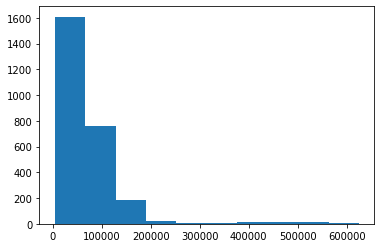

In [ ]:
plt.hist(number, )

# Pars 2 for 10Q + NRC

In [ ]:
document['MMM'].keys()

dict_keys(['2019-02-07', '2018-02-08', '2017-02-09', '2016-02-11', '2015-02-12', '2014-02-13', '2013-02-14', '2012-02-16', '2011-02-16'])

In [ ]:
%%time

four = 0
rightfour = 0
notf = 0
cto = 0
necto = 0
i = 0
number = []
for i in tqdm(list(document.keys())[:]):
  for ii in list(document[i]['10Q'].keys())[:]:
    for_ = document[i]['10Q'][ii]['item_2_raw']
    regex = re.compile(r'(Item\s*2\s*[.:-–])(\s*Management.s)|(Item\s*3\s*[.:-–])(\s*Quantitative)|(Item555\s*4\s*\.)(\s*Control)', re.IGNORECASE)
    matches = regex.finditer(for_)
    test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])
    
    if len(test_df) == 4:

      if test_df[0].str.contains('3')[3] and test_df[0].str.contains('2')[2]:
        # display(i, ii, test_df, 'stop')
        start = test_df[1][2]
        stop  = test_df[1][3] 
          # if (stop - start) > 20000 and (stop - start) < 250000:
        # document[i]['10Q'][ii]['affect'] = NRCLex(document[i]['10Q'][ii]['item_2_raw'][start:stop]).affect_frequencies
        # document[i]['10Q'][ii]['numb_aff'] = len(NRCLex(document[i]['10Q'][ii]['item_2_raw'][start:stop]).affect_list)/(len((NRCLex(document[i]['10Q'][ii]['item_2_raw'][start:stop]).words)))
        # document[i]['10Q'][ii]['len_2item'] = len(document[i]['10Q'][ii]['item_2_raw'][start:stop])
          
        #   # display(i, ii, test_df, 'stop')
        #   cto+=1
        # else:
        #   necto+=1

      # number.append(test_df[1][3] - test_df[1][2])

        four+=1
      else:
        notf+=1

# display(four, rightfour, notf)


100%|██████████| 505/505 [54:49<00:00,  6.51s/it]

CPU times: user 54min 44s, sys: 3.39 s, total: 54min 48s
Wall time: 54min 49s


In [ ]:
dd = test_df.copy()
dd

,0,1,2
0,Item 2. Managements,3243,3263
1,Item 3. Quantitative,3361,3381
2,Item 2. Managements,54638,54658
3,Item 3. Quantitative,137441,137461


# 'EXPECTS' EXTRACT

In [ ]:
def exp(diii):
  sent_token = list(map(lambda x: " ".join(x.split()), nltk.sent_tokenize(diii)))
  word_to_analyze = 'expect'
  # type(document['MMM']['2019-02-07']['item_7_raw'])
  exp_ = (pd.DataFrame(sent_token)[pd.DataFrame(sent_token)[0].str.contains(word_to_analyze, flags=re.IGNORECASE, regex = True)]).drop_duplicates().reset_index(drop=True)
  len_ = exp_.shape[0]
  exp_ = ' '.join(exp_[0])
  return(exp_, len_, sent_token)

In [ ]:
%%time
exp_, len_, sent_token = exp(document['MMM']['10Q']['2020-07-28']['item_2_raw'])

CPU times: user 48.4 s, sys: 127 ms, total: 48.5 s
Wall time: 48.3 s


# Загрузка document

In [15]:
%%time
# pickle.dump(document, open(my_dir + "dic_all_last.p", "wb"))  # save 
document = pickle.load (open(my_dir + "dic_all.p", "rb"))   # open 
 

CPU times: user 1.1 s, sys: 318 ms, total: 1.42 s
Wall time: 2.68 s


# TDIF - Pipline - Bayes/RF/etc

### Training 

In [ ]:
all = ["It is going to rain Today. today I am not going outside. I am Going to watch the season premiere."]
Document1 = "It is going to rain Today."
Document2= "today I am not going outside."
Document3= "I am Going to watch the season premiere."
Doc = [Document1 ,
       Document2 , 
       Document3
       ]
Doc1 = [Document1]
Doc2 = [Document2]
Doc3 = [Document3]
print(Doc)  # Doc like 

['It is going to rain Today.', 'today I am not going outside.', 'I am Going to watch the season premiere.']


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1), )
vectorizer.fit_transform(Doc)

<3x7 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

###### Cos

In [ ]:
display(vectorizer.get_feature_names())
pd.DataFrame(vectorizer.transform(Doc1).toarray(), columns = vectorizer.get_feature_names())
display(Doc2, Doc1, cosine_similarity(vectorizer.transform(Doc2).toarray(), vectorizer.transform(Doc1).toarray()))

['going', 'outside', 'premiere', 'rain', 'season', 'today', 'watch']

['today I am not going outside.']

['It is going to rain Today.']

array([[0.48111972]])

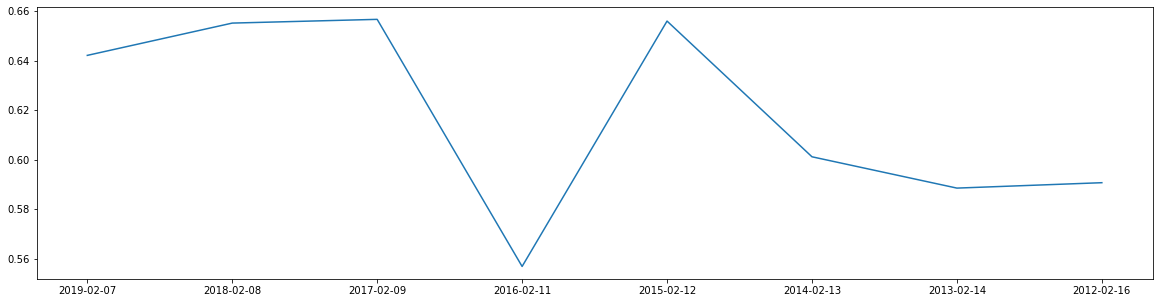

In [ ]:
# cosine_similarity
cos_sim = []
cos_dat = []
for i in range(len(document['MMM'].keys()) - 2):
  # display(i)
  ii = list(document['MMM'].keys())[i]
  rr = list(document['MMM'].keys())[i+1]
  # display(ii, rr)
  cos_sim.append(cosine_similarity(document['MMM'][ii]['expect_7_TFID'], document['MMM'][rr]['expect_7_TFID']))
  cos_dat.append(ii)
  # display(document['MMM'][list(document['MMM'].keys())[i]]['expect_7_TFID'])
plt.figure(figsize=(20,5))
plt.plot(pd.Series(cos_sim, cos_dat))
plt.show()

###### Jaccard

In [ ]:
# d = vectorizer.transform(Doc2).toarray()[0].round(2)
# f = vectorizer.transform(Doc1).toarray()[0].round(2)
# display(vectorizer.get_feature_names(), Doc2, Doc1, list(d),list(f), type([0,1]), type(list(d)))
# jaccard_score(list(d),list(f))

### My train

In [ ]:
%%time
all = []
for i in tqdm(list(document.keys())[:]):
  for ii in [d for d in document[i].keys() if d != '10Q']:
    all.append(document[i][ii]['expect_7'])
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
dd = vectorizer.fit_transform(all)

# my_data = {}
for i in list(document.keys())[:]:
  for ii in [d for d in document[i].keys() if d != '10Q']:
    X = vectorizer.transform([document[i][ii]['expect_7']])
    # document[i][ii]['expect_7_TFID'] = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
    document[i][ii]['expect_7_TFID'] = X.toarray()


Wall time: 30 s


In [ ]:
document[i][ii]['expect_7_TFID'].shape

(1, 319184)

## Pipline

##### Data = StockTwit. Достаем лебелы с помощью stock

In [17]:
%%time
# df = pd.read_csv(u'F:/Мой диск/' +       'NLP-of-StockTwits-data-for-predicting-stocks-master/Data/Combined_FAANG_binary_previous.csv', sep=',')
df = pd.read_csv(u'/content/drive/MyDrive/NLP-of-StockTwits-data-for-predicting-stocks-master/Data/Combined_FAANG_binary_previous.csv', sep=',')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df = df.rename(columns={'symbol':'Symbol'})
df = df[df['message'].notna()]
display(df.shape)
# df.drop(df[df['Date'] <= '2019-07-20'].index, inplace = True) 
display(df.shape,  df["label"].value_counts())

(2566858, 9)

(2566858, 9)

1    1357115
0    1209743
Name: label, dtype: int64

CPU times: user 6.56 s, sys: 607 ms, total: 7.17 s
Wall time: 9.56 s


In [ ]:
# достаем юзеров

# dd = pd.pivot_table(df,
#                index = ['user'],
#                values = 'message',
#                aggfunc = ['count']
#                )
# # dd.sort_values([('count', 'message')], ascending=False)
# good_user = list(dd[dd[('count', 'message')] > 5000].index)

# pivo1 = pd.pivot_table(df,
#                index = ['user', 'Year'],
#                values = 'message',
#                aggfunc = ['count']
#                )
# pivo1.reset_index(inplace=True)
# pivo1.columns = ['user', 'Year', 'count']

# pd.pivot_table(pivo1[pivo1['user'].isin(good_user)],
#                index = ['user'],
#                values = 'count',
#                aggfunc = ['sum', 'count']
              #  )

In [22]:
stock['%_today']   = (stock['4. close']/stock['1. open'] - 1)*100
stock['%_today_1'] = np.where(stock['Symbol'].shift(-1) == stock['Symbol'].shift(0), stock['%_today'].shift(-1), 0)

# create little stock
stock_for_tweet = stock[stock['Symbol'].isin(df['Symbol'].unique())]

# # shift(-1)
# t_stock_all = pd.DataFrame()
# for i in stock_for_tweet['Symbol'].unique():
#   t_stock = stock_for_tweet[stock_for_tweet['Symbol'] == i][['5. adjusted close']]
#   t_stock['%_1'] = (t_stock['5. adjusted close'].shift(-1)/t_stock['5. adjusted close'].shift(0)-1)*100
#   t_stock['%_5'] = (t_stock['5. adjusted close'].shift(-5)/t_stock['5. adjusted close'].shift(0)-1)*100
#   t_stock['%_-1'] = (t_stock['5. adjusted close'].shift(0)/t_stock['5. adjusted close'].shift(1)-1)*100
#   t_stock_all = t_stock_all.append(t_stock)

# stock_for_tweet = pd.merge(t_stock_all, stock_for_tweet, left_index=True, right_index=True)

#labeling
stock_for_tweet['label_today']    = np.where(stock_for_tweet['%_today'] > 0, 1, 0)
stock_for_tweet['label_tomorrow'] = np.where(stock_for_tweet['%_today_1'] > 0, 1, 0)
# stock_for_tweet['label-1'] = np.where(stock_for_tweet['%_-1'] > 0, 1, 0)
# stock_for_tweet['label5'] = np.where(stock_for_tweet['%_5'] > 0, 1, 0)

In [24]:
df_new = pd.merge(df, stock_for_tweet, on = ['Date', 'Symbol'], how = 'inner')
df_new

,Symbol,message,datetime,user,message_id,Date,Time,label,Year,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,%_today,%_today_1,label_today,label_tomorrow
0,AAPL,qq next 60min confirm start rally aapl coming ...,2015-12-21 18:37:24,191996.0,47148173.0,2015-12-21,18:37:24,1,2015,107.28,107.37,105.57,107.33,24.819199,47590610.0,0.0,1.0,0.046607,-0.158287,1,0
1,AAPL,aapl apple going act like market bad run,2015-12-21 15:52:02,417174.0,47135188.0,2015-12-21,15:52:02,1,2015,107.28,107.37,105.57,107.33,24.819199,47590610.0,0.0,1.0,0.046607,-0.158287,1,0
2,AAPL,spy vix messenger positing aapl,2015-12-21 17:21:25,228682.0,47142702.0,2015-12-21,17:21:25,1,2015,107.28,107.37,105.57,107.33,24.819199,47590610.0,0.0,1.0,0.046607,-0.158287,1,0
3,AAPL,aapl 106 67 get fast flush covering,2015-12-21 19:23:10,596943.0,47151096.0,2015-12-21,19:23:10,1,2015,107.28,107.37,105.57,107.33,24.819199,47590610.0,0.0,1.0,0.046607,-0.158287,1,0
4,AAPL,aapl flash buying calls small position shall see,2015-12-21 16:16:45,508999.0,47137277.0,2015-12-21,16:16:45,1,2015,107.28,107.37,105.57,107.33,24.819199,47590610.0,0.0,1.0,0.046607,-0.158287,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391348,NFLX,snhy v nflx withing shouting distance even dry...,2009-09-24 19:47:35,78.0,604077.0,2009-09-24,19:47:35,0,2009,47.15,47.15,46.18,46.62,6.659993,533400.0,0.0,1.0,-1.124072,-0.086393,0,0
2391349,NFLX,nflx may go dtv news,2010-04-19 17:18:09,13327.0,1289251.0,2010-04-19,17:18:09,0,2010,85.25,86.60,82.77,84.80,12.114274,1924400.0,0.0,1.0,-0.527859,2.338975,0,1
2391350,NFLX,nflx june 100 calls,2010-05-24 14:15:38,9825.0,1423650.0,2010-05-24,14:15:38,1,2010,101.38,104.36,100.01,101.62,14.517128,2633300.0,0.0,1.0,0.236733,7.692308,1,1
2391351,NFLX,day aapl goog pcln nflx amzn nicely 39 think m...,2010-05-24 16:50:39,7399.0,1424532.0,2010-05-24,16:50:39,1,2010,101.38,104.36,100.01,101.62,14.517128,2633300.0,0.0,1.0,0.236733,7.692308,1,1


In [34]:

# df.drop(df[df['label']==0].index, inplace= True)
# df['label'].replace({-1:0}, inplace = True)
x_train, x_test, y_train, y_test, pr_train, pr_test, s_train, s_test, date_train, date_test = train_test_split(df_new['message'], df_new['label_tomorrow'], df_new['%_today_1'], df_new['Symbol'], df_new['Date'], test_size=0.1, random_state=42)

#### Data = document. Создать свою базу данных DataSeries вытаскивая их в цикле из Document?

In [ ]:
# x_train, x_test, y_train, y_test, pr_train, pr_test, s_train, s_test, indust_train, indust_test = train_test_split \
# (result_byes['message'], result_byes['label'], result_byes['250_%'], result_byes['Symbol'], result_byes['Industry'], test_size=0.1, random_state=42)

#### Model Byes

In [26]:
text_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                     ('tfidf', TfidfTransformer(use_idf=True, norm='l2')),
                     ('clf', MultinomialNB(alpha=0.2))])

tuning_param = {
     'vect__ngram_range': [(1, 1), (1, 2)],
     'tfidf__use_idf': (True, False),
     'tfidf__norm': ('l1', 'l2'),
     'clf__alpha': [1, 0.1,0.2,0.3,0.4,0.5]
}

best_param = {
    'vect__ngram_range': [(1, 1)],
    'tfidf__use_idf': ([True]),
    'tfidf__norm': (['l2']),
    'clf__alpha': [0.2]
}

# score = 'f1_macro'
# model = GridSearchCV(text_pipe, tuning_param, cv=5, scoring=score)


In [27]:
%%time
# model.fit(x_train, y_train)

# OR

text_pipe.fit(x_train, y_train)

CPU times: user 1min 21s, sys: 1.53 s, total: 1min 22s
Wall time: 1min 22s


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True))],
         verbose=False)

In [28]:
%%time
pred_proba_te = text_pipe.predict_proba(x_test)
pred_proba_tr = text_pipe.predict_proba(x_train)
pred          = text_pipe.predict(x_test)
pred_train    = text_pipe.predict(x_train)

# OR

# pred_proba_te = model.predict_proba(x_test)
# pred_proba_tr = model.predict_proba(x_train)
# pred          = model.predict(x_test)
# pred_train    = model.predict(x_train)


CPU times: user 2min 9s, sys: 215 ms, total: 2min 9s
Wall time: 2min 9s


In [ ]:
# model.best_estimator_
# model.best_params_

# # save best and load
# joblib.dump(grid.best_params_, 'best_tfidf.pkl', compress = 1) # Only best parameters

# # Load best parameters
# tfidf_params = joblib.load('best_tfidf.pkl')

# text_pipe.set_params(**tfidf_params)

In [29]:
print(classification_report(y_test, pred, digits=4))

              precision    recall  f1-score   support

           0     0.5549    0.5588    0.5568    119768
           1     0.5541    0.5502    0.5522    119368

    accuracy                         0.5545    239136
   macro avg     0.5545    0.5545    0.5545    239136
weighted avg     0.5545    0.5545    0.5545    239136



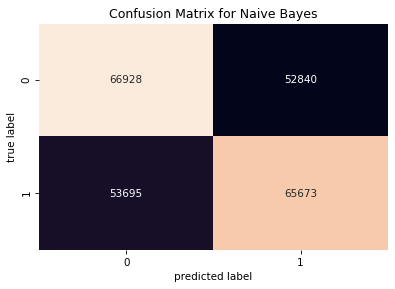

In [30]:
plt.figure(dpi=75)
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.ylabel('true label')
plt.xlabel('predicted label')
# plt.savefig("assets/confusion_matrix.png")
plt.show()

              precision    recall  f1-score   support

           0     0.5673    0.4778    0.5187    114423
           1     0.5815    0.6656    0.6207    124713

    accuracy                         0.5758    239136
   macro avg     0.5744    0.5717    0.5697    239136
weighted avg     0.5747    0.5758    0.5719    239136



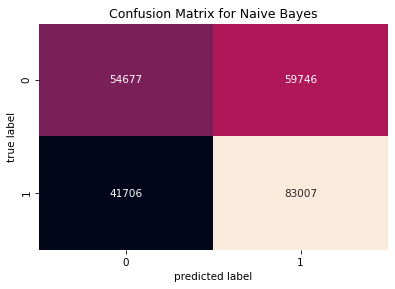

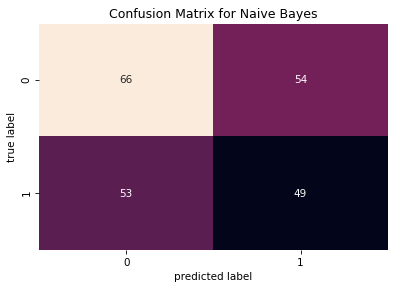

In [43]:
test_df

,label,pred,%_today,Symbol,Date,sign
408700,0,0,-1.292901,AAPL,2018-01-26,test
2095222,0,1,-2.459698,NFLX,2020-04-20,test
2255034,0,0,-1.107839,NFLX,2019-07-15,test
897617,0,1,-0.912662,AAPL,2018-12-14,test
250739,0,0,-0.342418,AAPL,2019-08-21,test
...,...,...,...,...,...,...
531404,1,1,0.895916,AAPL,2018-07-16,test
1558899,1,1,0.026583,FB,2019-09-17,test
1514336,0,0,-2.397959,AMZN,2015-01-14,test
330524,0,1,-0.018880,AAPL,2016-03-18,test


In [57]:
ff = pd.pivot_table(test_df,
              index = ['Symbol', 'Date'],
              values = ['pred', 'label','%_today'],
              aggfunc = ['count', 'mean'])
ff.reset_index().to_excel(my_dir + '1703.xlsx')
ff

count                 mean                
                  %_today label pred   %_today label      pred
Symbol Date                                                   
AAPL   2009-07-30       1     1    1  0.246582     1  1.000000
       2009-08-24       1     1    1 -0.035348     0  0.000000
       2009-09-03       1     1    1  1.813951     1  0.000000
       2009-09-04       2     2    2 -0.028905     0  0.500000
       2009-09-08       1     1    1 -0.949184     0  0.000000
...                   ...   ...  ...       ...   ...       ...
NFLX   2020-07-16     530   530  530 -0.379898     0  0.362264
       2020-07-17     226   226  226  2.712925     1  0.442478
       2020-07-20      56    56   56 -3.142292     0  0.464286
       2020-07-21      41    41   41 -0.481521     0  0.512195
       2020-07-22       3     3    3 -2.758944     0  0.666667

[9718 rows x 6 columns]

In [61]:
stock_for_tweet[(stock_for_tweet['Date'] == '23.01.2017')|(stock_for_tweet['Date'] == '24.01.2017')]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Symbol,Date,%_today,%_today_1,label_today,label_tomorrow
date,,,,,,,,,,,,,,
2017-01-23,120.00,120.8100,119.77,120.08,28.385449,22050218.0,0.0,1.0,AAPL,2017-01-23,0.066667,0.351317,1,1
2017-01-24,119.55,120.1000,119.50,119.97,28.359447,23211038.0,0.0,1.0,AAPL,2017-01-24,0.351317,1.212423,1,1
2017-01-23,806.80,818.5000,805.08,817.88,817.880000,2797474.0,0.0,1.0,AMZN,2017-01-23,1.373327,0.053528,1,1
2017-01-24,822.00,823.9900,814.50,822.44,822.440000,2971740.0,0.0,1.0,AMZN,2017-01-24,0.053528,1.299362,1,1
2017-01-23,127.31,129.2500,126.95,128.93,128.930000,16593563.0,0.0,1.0,FB,2017-01-23,1.272484,-0.007729,1,0
2017-01-24,129.38,129.9000,128.38,129.37,129.370000,15162724.0,0.0,1.0,FB,2017-01-24,-0.007729,1.138462,0,1
2017-01-23,831.61,845.5428,828.70,844.43,844.430000,2457377.0,0.0,1.0,GOOGL,2017-01-23,1.541588,0.301070,1,1
2017-01-24,846.98,851.5200,842.28,849.53,849.530000,1688375.0,0.0,1.0,GOOGL,2017-01-24,0.301070,0.574073,1,1
2017-01-23,138.65,139.4900,137.31,137.39,137.390000,7433896.0,0.0,1.0,NFLX,2017-01-23,-0.908763,1.448121,0,1


Symbol       Date   count                 mean                
                       %_today label pred   %_today label      pred
0      AAPL 2009-07-30       1     1    1  0.246582     1  1.000000
1      AAPL 2009-08-24       1     1    1 -0.035348     0  0.000000
2      AAPL 2009-09-03       1     1    1  1.813951     1  0.000000
3      AAPL 2009-09-04       2     2    2 -0.028905     0  0.500000
4      AAPL 2009-09-08       1     1    1 -0.949184     0  0.000000
...     ...        ...     ...   ...  ...       ...   ...       ...
9713   NFLX 2020-07-16     530   530  530 -0.379898     0  0.362264
9714   NFLX 2020-07-17     226   226  226  2.712925     1  0.442478
9715   NFLX 2020-07-20      56    56   56 -3.142292     0  0.464286
9716   NFLX 2020-07-21      41    41   41 -0.481521     0  0.512195
9717   NFLX 2020-07-22       3     3    3 -2.758944     0  0.666667

[9718 rows x 8 columns]

In [35]:
train_df = pd.DataFrame({'label': y_train, 'pred': pred_train, '%_today': pr_train, \
                         'Symbol': s_train, 'Date': date_train})
train_df['sign'] = 'train'
test_df = pd.DataFrame({'label': y_test, 'pred': pred, '%_today': pr_test, \
                         'Symbol': s_test, 'Date': date_test})
test_df['sign'] = 'test'
all_df = test_df.append(train_df)
# all_df['proba_55'] = np.where(all_df['proba_1'] > 0.525, 1, np.where(all_df['proba_1'] < 0.475, -1, 0))
all_df

,label,pred,%_today,Symbol,Date,sign
408700,0,0,-1.292901,AAPL,2018-01-26,test
2095222,0,1,-2.459698,NFLX,2020-04-20,test
2255034,0,0,-1.107839,NFLX,2019-07-15,test
897617,0,1,-0.912662,AAPL,2018-12-14,test
250739,0,0,-0.342418,AAPL,2019-08-21,test
...,...,...,...,...,...,...
110268,0,0,-0.006958,AAPL,2017-03-31,train
1692743,0,0,-1.546132,GOOGL,2019-07-18,train
2356330,0,1,-1.491283,NFLX,2016-06-17,train
2229084,1,1,2.846639,NFLX,2016-07-01,train


In [36]:
pd.pivot_table(all_df,
               index= ['sign', 'pred'],
               values = ['%_today'],
               aggfunc=['count', 'mean']
               )

count      mean
            %_today   %_today
sign  pred                   
test  0      120623 -0.137406
      1      118513  0.172712
train 0     1084354 -1.010358
      1     1067863  1.055086

In [ ]:
# train_df = pd.DataFrame({'label': y_train, 'pred': pred_train, '250_%': pr_train, 'proba_1':pd.DataFrame(pred_proba_tr, index=pr_train.index)[1], \
#                          'Symbol': s_train, 'Industry': indust_train})
# train_df['sign'] = 'train'
# test_df = pd.DataFrame({'label': y_test, 'pred': pred, '250_%': pr_test, 'proba_1':pd.DataFrame(pred_proba_te, index = y_test.index)[1], \
#                          'Symbol': s_test, 'Industry': indust_test})
# test_df['sign'] = 'test'
# all_df = test_df.append(train_df)
# all_df['proba_55'] = np.where(all_df['proba_1'] > 0.525, 1, np.where(all_df['proba_1'] < 0.475, -1, 0))
# all_df

##### Разбивка в цикле по годам

In [ ]:
%%time
# All in sycles
Pred_all = pd.DataFrame()
for year in list(range(2012,2020)):

  Train = result_byes.loc[result['Year'] < year]
  Test  = result_byes.loc[result['Year'] == year]
  
  text_pipe.fit(Train['message'], Train['label'])

  # pred_proba_te = text_pipe.predict_proba(x_test)
  pred_proba = pd.DataFrame(text_pipe.predict_proba(Test['message']))[1]
  pred                    = text_pipe.predict(Test['message'])
  # pred_train= text_pipe.predict(x_train)

  Test['Forecast'] = pred
  Test['proba_1']  = np.array(pred_proba)

  Pred_all = Pred_all.append(Test)


CPU times: user 5min, sys: 632 ms, total: 5min
Wall time: 5min


In [ ]:
Pred_all['proba_55'] = np.where(Pred_all['proba_1'] > 0.60, 1, np.where(Pred_all['proba_1'] < 0.4, -1, 0))

pd.pivot_table(Pred_all[Pred_all['proba_55'] != 100],
               index = [
                        # 'Year', 
                        'Industry',
                        'Forecast', 
                        # 'proba_55'
                        ],
               values = '250_%',
               aggfunc=['count', 'mean']

               )

count       mean
                                250_%      250_%
Industry               Forecast                 
Communication Services 0           34  20.196494
                       1           52  23.719007
Consumer Discretionary 0          136  17.531416
                       1          144  14.673101
Consumer Staples       0           88  10.649886
                       1           33  16.251092
Energy                 0          107  10.080509
                       1            4  25.899257
Financials             0           98  17.329724
                       1           50  15.538070
Health Care            0          138  18.935527
                       1          160  19.724157
Industrials            0          223  20.759493
                       1           92  17.239437
Information Technology 0          231  22.795013
                       1          142  24.862590
Materials              0           68  12.934549
                       1           14  18.659048
Real Estate            0          115  15.162821
                       1           24  10.695681
Utilities              0           69  15.082919
                       1           25  17.043065

count       mean
              250_%      250_%
Year Forecast                 
2012 0          125  23.127761
     1           78  21.776567
2013 0          136  31.935673
     1           97  31.382158
2014 0          149  20.520784
     1          100  16.046740
2015 0          165  -2.875285
     1           98  -2.097718
2016 0          156  32.538365
     1          120  25.989495
2017 0          164  19.740595
     1          119  22.008771
2018 0          184   7.401366
     1          115  16.048414
2019 0          150   9.667895
     1           91  24.930784

In [ ]:
pd.pivot_table(all_df[all_df['sign'] == 'train'],
               index = ['sign', 'Industry', 'pred' ],
               values = '250_%',
               aggfunc=['count', 'mean']

               )

count       mean
                                  250_%      250_%
sign  Industry               pred                 
train Communication Services 0       28   1.679296
                             1       59  32.917197
      Consumer Discretionary 0      157   6.137659
                             1      120  31.192262
      Consumer Staples       0       93   7.861142
                             1       20  35.238089
      Energy                 0      102   8.321885
                             1        2  28.513925
      Financials             0       89   9.496505
                             1       47  29.150229
      Health Care            0       87   3.267181
                             1      195  27.982509
      Industrials            0      169  12.664734
                             1      134  28.183837
      Information Technology 0      129   3.338030
                             1      229  32.968988
      Materials              0       65  10.796674
                             1       12  38.833266
      Real Estate            0       75   7.969533
                             1       60  21.761598
      Utilities              0       54  10.152457
                             1       39  25.711673

count       mean
           250_%      250_%
sign  pred                 
test  0       94  12.531752
      1      123  23.839261
train 0      748   9.096155
      1     1201  23.161663

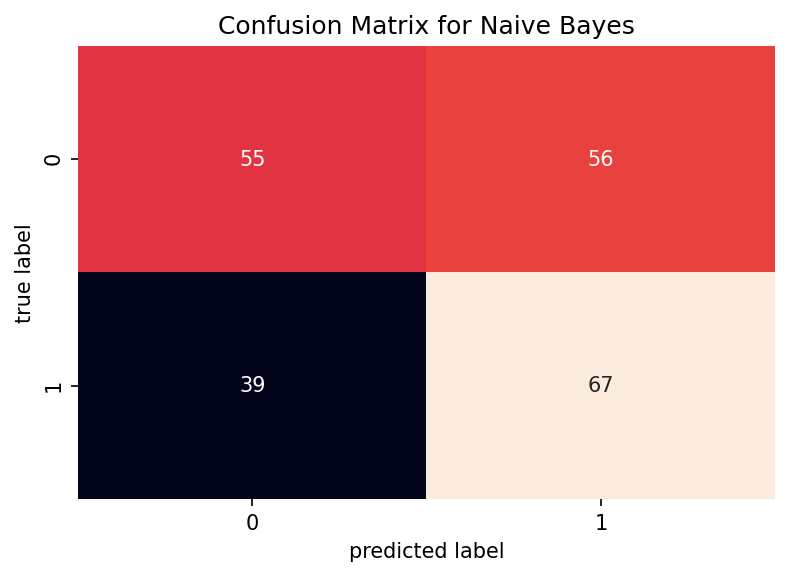

# -Lexicon Loughran and McDonald

#### Load sentiment data

In [ ]:
sentiment_df = pd.read_csv(lmdict_dir + 'LoughranMcDonald_SentimentWordLists_2018.csv', sep = ';')
# sentiment_df = pd.read_excel(lmdict_dir + 'LoughranMcDonald_SentimentWordLists_2018.xlsx')

sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()


,word
sentiment,
Constraining,184
Litigious,904
Negative,2353
Positive,352
StrongModal,19
Uncertainty,297
WeakModal,27


#### Создали словарь sentiment_dict

In [ ]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

In [ ]:
document.keys()
document['MMM'].keys()
document['MMM']['2019-02-07'].keys()
nltk.sent_tokenize(document['MMM']['2019-02-07']['item_7_raw'])

#### Тот самый McDonald

In [ ]:
%%time

l_all = []
p_all = []

# for i in tqdm(document.keys()):
  # display(i)
  # for ii in document[i].keys():
for i in tqdm(list(document.keys())[:]):
  for ii in list(document[i].keys())[:]:

      if 'item_7_raw' in document[i][ii].keys() and (len(document[i][ii]['item_7_raw']) > 20000 and len(document[i][ii]['item_7_raw']) < 200000):
        document[i][ii]['McDonald'] = {}
      
      # display(len(document[i][ii].keys()), (document[i][ii].keys()), len(document[i][ii]['item_7_raw']))
        text = (document[i][ii]['item_7_raw'])
        sentences = nltk.sent_tokenize(text)
        
        tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x.lower()) for x in (sentences)]
        tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
        document[i][ii]['McDonald'] = tone_lmdict_df.mean()


100%|██████████| 505/505 [17:24<00:00,  2.07s/it]

CPU times: user 17min 24s, sys: 427 ms, total: 17min 24s
Wall time: 17min 25s


In [ ]:
for i in tqdm(list(document.keys())[:]):
  for ii in list(document[i].keys())[:]:
    if 'item_7_raw' in document[i][ii].keys() and (len(document[i][ii]['item_7_raw']) > 20000 and len(document[i][ii]['item_7_raw']) < 200000):
    #   display(document[i][ii]['McDonald'])
      # display(document[i][ii].keys())#, len(document[i][ii]['item_7_raw']()))
      display((document[i][ii]['McDonald']))
      # display((document[i][ii]['affect_frequencies_7_row']['trust']))

# -finBERT
 

In [ ]:
labels = {0:'neutral', 1:'positive',2:'negative'}
num_labels= len(labels)
vocab = "finance-uncased"
#vocab_path = "/home/root/new_bert_vocab_uncased_8000"
vocab_path = '/content/drive/MyDrive/Marat/analyst_tone/vocab'
pretrained_weights_path = "/content/drive/MyDrive/Marat/analyst_tone/pretrained_weights" # this is pre-trained FinBERT weights
fine_tuned_weight_path = "/content/drive/MyDrive/Marat/analyst_tone/fine_tuned.pth"      # this is fine-tuned FinBERT weights
max_seq_length=256
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device='cpu'
display(torch.cuda.is_available())

True

In [ ]:
model = BertClassification(weight_path= pretrained_weights_path, num_labels=num_labels, vocab=vocab)
model.load_state_dict(torch.load(fine_tuned_weight_path, map_location=torch.device(device)))
model.to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


KeyboardInterrupt: ignored

In [ ]:
# sentences = ['there is a shortage of capital, and we need extra financing', "growth is strong and we have plenty of liquidity", "there are doubts about our finances", "profits are flat"]
tokenizer = BertTokenizer(vocab_file = vocab_path, do_lower_case = True, do_basic_tokenize = True)

##### Тот самый finBert

In [ ]:
%%time

l_all = []
p_all = []

# for i in tqdm(document.keys()):
#   display(i)
#   for ii in document[i].keys():
for i in tqdm(list(document.keys())[300:]):
  for ii in list(document[i].keys())[:]:
    # 
    # try:
      if 'item_7_raw' in document[i][ii].keys() and (len(document[i][ii]['item_7_raw']) > 20000 and len(document[i][ii]['item_7_raw']) < 200000):
        document[i][ii]['finBert'] = {}
      
      # display(len(document[i][ii].keys()), (document[i][ii].keys()), len(document[i][ii]['item_7_raw']))
        text = (document[i][ii]['item_7_raw'])

        sentences = nltk.sent_tokenize(text)
        
        l, p = bert(sentences)
        document[i][ii]['finBert'] = np.where(pd.DataFrame(l)[0] == 'negative', -1, np.where(pd.DataFrame(l)[0] == 'positive', 1, 0)).mean()
    # except:
    #   continue

100%|██████████| 205/205 [2:18:27<00:00, 40.52s/it]

CPU times: user 2h 18min 23s, sys: 6.1 s, total: 2h 18min 29s
Wall time: 2h 18min 27s


# -BERT pipline


In [ ]:
nlp = pipeline("sentiment-analysis")

## Тот самый pipline basicBert

In [ ]:
%%time

# for i in tqdm(document.keys()):
for i in tqdm(list(document.keys())[:]):
  for ii in list(document[i].keys())[:]:
    # display(i, ii)
    document[i][ii]['bert_negative'] = {}

    # if len(document[i][ii])>2:                                                                                 # КЛЮЧ НЕ???

    text = (document[i][ii]['item_7_raw'])
    # display(len(text))
    max_ = 0
    label    = []
    score    = []
    my_text  = []

    sentences = nltk.sent_tokenize(text)
    for sentence in (sentences):
        # print(sentence)
        if len(sentence) < 100 and len(sentence) > 3:
        # max_ = max(len_, max_)
        
          # if 'item_7_raw' in document[i][ii].keys() and (len(document[i][ii]['item_7_raw']) > 20000 and len(document[i][ii]['item_7_raw']) < 200000):
            result = nlp(sentence)
            label.append(result[0]['label'])
              # score.append(result[0]['score'])
              # my_text.append(sentence)
              # display('yes')
        # else:
        #   # display(len_, sentence)
        #   continue
    est = np.where(pd.Series(label) == 'NEGATIVE', 0, 1).mean()
    document[i][ii]['bert_negative'] = est

    # else:
    #     document[i][ii]['bert_negative'] = 0    
    # ...........
    


100%|██████████| 505/505 [1:32:24<00:00, 10.98s/it]

CPU times: user 1h 32min 14s, sys: 12.5 s, total: 1h 32min 26s
Wall time: 1h 32min 24s


# -NRCLex
# Запись эмоций в document[CIK][year]['affect_frequencies'])

In [ ]:
%%time
# text_object = NRCLex(raw_10k[doc_start:doc_end])
# .words
# text_object.sentences
# text_object.affect_list
# text_object.affect_dict
# text_object.raw_emotion_scores
# text_object.top_emotions
# text_object.affect_frequencies

In [ ]:
# pi['su'] = pi.sum(axis=1)
pi[(pi['su'] == 5)&(pi['trust'] == 1)]

emotion,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,su
word,,,,,,,,,,,
accolade,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,5.0
advocacy,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,5.0
angel,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,5.0
aspiration,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,5.0
award,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
volunteer,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,5.0
warn,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0
worship,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,5.0


In [ ]:
# pi = pd.pivot_table(emolex_df,
#                index = 'word',
#                columns = 'emotion',
#                values = 'association'
#                )
pi

emotion,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,su
word,,,,,,,,,,,
abacus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,5.0
abate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
zone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zoo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zoological,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Аанлиз текстовой библиотеки Мухамеда

# filepath = my_dir + "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
# emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df.head(12)
# emolex_df[(emolex_df['emotion'] == 'trust')&(emolex_df['association'] == 1)]['word']

,word,emotion,association
0,abacus,sadness,0
1,abacus,surprise,0
2,abacus,trust,1
3,abandon,anger,0
4,abandon,anticipation,0
5,abandon,disgust,0
6,abandon,fear,1
7,abandon,joy,0
8,abandon,negative,1
9,abandon,positive,0


In [ ]:
# COMAND FOU NRC

# text_object = NRCLex('Fine dog. Fine cat')
# text_object = NRCLex(text)
# text_object.words
# text_object.sentences
# text_object.affect_list
# text_object.affect_dict
# text_object.raw_emotion_scores
# text_object.top_emotions
# text_object.affect_frequencies

In [ ]:
# n=0
# m=0
# k=0
# v=0
# # for ii in document.keys():
# for ii in tqdm(list(document.keys())[:25]):
# # for ii in ['AMZN']:
#     for i in document[ii].keys():
#         if document[ii][i]['affect_frequencies_7_row'] == 1000:
#             v+=1
#         elif len(document[ii][i]['affect_frequencies_7_row']) == 11:
#             # display((document[ii][i]['affect_frequencies_7_row']))
#             n+=1
#         elif len(document[ii][i]['affect_frequencies_7_row']) == 0:
#             m+=1

#         else:
#             continue
# display(n, m, k, v)

100%|██████████| 25/25 [00:00<00:00, 7819.36it/s]


110

0

0

76

## Та самая affect_frequencies_7_row

In [ ]:
display(i,ii)
document[i]['10Q'][ii]['item_2_raw']
# NRCLex(document[i]['10Q'][ii]['expect_2']).affect_frequencies
exp(document[i]['10Q'][ii]['item_2_raw'])

'MMM'

'2020-10-27'

('The allowances for bad debts and cash discounts are based on the best estimate of the amount of expected credit losses in existing accounts receivable and anticipated cash discounts. The Company determines the allowances based on historical write-off experience by industry and regional economic data, current expectations of future credit losses, and historical cash discounts. When a credit loss exists, the Company compares the present value of cash flows expected to be collected from the debt security with the amortized cost basis of the security to determine what allowance amount, if any, should be recorded. In light of circumstances, including the country’s unstable environment and heightened unrest leading to sustained lack of demand, and expectation that these circumstances will continue for the foreseeable future, during May 2019, 3M concluded it no longer met the criteria of control in order to continue consolidating its Venezuelan operations. 2018-19, 2019-04, 2019-05, 2019-11

In [ ]:
%%time

# for i in tqdm(document.keys()):
  # for ii in (document[i].keys()): 
  # for ii in (document[i]['10Q'].keys()):                                      # переделал под 10Q
for i in tqdm(list(document.keys())[:100]):
  for ii in list(document[i]['10Q'].keys())[:]:                                  # Добавил 10Q
    
    # if 'item_7_raw' in document[i][ii].keys() and (len(document[i][ii]['item_7_raw']) > 20000 and len(document[i][ii]['item_7_raw']) < 200000):
    if 'item_2_raw' in document[i]['10Q'][ii].keys(): #and (len(document[i][ii]['item_7_raw']) > 20000 and len(document[i][ii]['item_7_raw']) < 200000):  
      e, l = exp(document[i]['10Q'][ii]['item_2_raw'])
      document[i]['10Q'][ii]['expect_2'] = e
      document[i]['10Q'][ii]['len_ex_2'] = l
      # document[i][ii]['affect_frequencies_7_row'] = {}
      # document[i][ii]['aff_frequencies_7_row'] = NRCLex(document[i][ii]['item_7_raw']).affect_frequencies
      document[i]['10Q'][ii]['aff_expOF7'] = NRCLex(document[i]['10Q'][ii]['expect_2']).affect_frequencies

      # document[i]['10Q'][ii]['affect_frequencies_2_row'] = {}
      # document[i]['10Q'][ii]['affect_frequencies_2_row'] = NRCLex(document[i]['10Q'][ii]['item_2_raw']).affect_frequencies





NameError: ignored

# Сбор информации в датафрейм
##  БЕРЕМ DOCUMENT И ИЗ НЕГО ВЫЬТАСКИВАЕМ ДАТЫ И СИМБОЛЫ.



In [ ]:
%%time

n = 0
nn= 0
affe = []
plot_1 = []
date = []
symb = []
len7 = []
dona = []
bert = []
fin_bert = []
pip_bert = []
len_10k = []
exp_7 = []
len_exp_7 = []


# for ii in ['AMZN']: # БЕРЕМ STOCK_FOR ПОТОМУ ЧТО ТОЛЬКО ТАМ ITEM7=50K 
for ii in tqdm(list(document.keys())[:]): 
    # display(ii)
    for i in [d for d in document[ii].keys() if d != '10Q']:  #['2020-02-24', '2019-02-25', '2018-02-13', '2017-02-21']:
      n+=1
      date.append(i)
      symb.append(ii)
      affe.append((document[ii][i]['affect_frequencies_7_row']))
      dona.append((document[ii][i]['McDonald']))
      # bert.append((document[ii][i]['bert_negative']))
      fin_bert.append((document[ii][i]['finBert']))
      pip_bert.append((document[ii][i]['bert_negative']))
      len7.append(len(document[ii][i]['item_7_raw']))
      exp_7.append((document[ii][i]['aff_expOF7']))
      len_exp_7.append((document[ii][i]['len_ex_7']))





100%|██████████| 505/505 [00:00<00:00, 59678.90it/s]

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 13.9 ms


In [ ]:
# for 10Q
len_item_2 = []
affe_item_2 = []
date2 = []
symb2 = []
numb_aff = []

n = 0
d = 0
# for ii in ['AMZN']: # БЕРЕМ STOCK_FOR ПОТОМУ ЧТО ТОЛЬКО ТАМ ITEM7=50K 
for ii in tqdm(list(document.keys())[:]): 
    # display(ii)
    for i in document[ii]['10Q'].keys():
      n+=1
      if 'affect' in document[ii]['10Q'][i]:
        d+=1
        affe_item_2.append((document[ii]['10Q'][i]['affect']))
        len_item_2.append ((document[ii]['10Q'][i]['len_2item']))
        numb_aff.append ((document[ii]['10Q'][i]['numb_aff']))
        date2.append(i)
        symb2.append(ii)
display(n,d, pd.Series(date2).size)


100%|██████████| 505/505 [00:00<00:00, 21171.71it/s]


18584

12270

12270

In [ ]:
# for Byes

dateb = []
symbb = []
item7 = []


n = 0
d = 0
# for ii in ['AMZN']: # БЕРЕМ STOCK_FOR ПОТОМУ ЧТО ТОЛЬКО ТАМ ITEM7=50K 
for ii in tqdm(list(document.keys())[:]): 
    # display(ii)
    for i in document[ii].keys():
      n+=1
      if 'item_7_raw' in document[ii][i]:
        d+=1
        item7.append((document[ii][i]['item_7_raw']))
        dateb.append(i)
        symbb.append(ii)
display(n,d, pd.Series(dateb).size)

100%|██████████| 505/505 [00:00<00:00, 80347.60it/s]


2211

2211

2211

In [ ]:
print('affect_frequencies_7_row: {0} \r\nbert: {1} \r\ndate: {2} \r\nMcDonald: {3} \r\nlen7: {4} \r\nfin_bert: {5} \r\npip_bert: {6} \r\nexp_7: {7}'.format(\
pd.Series(affe).size,pd.Series(bert, dtype=float).size, \
pd.Series(date).size,pd.Series(dona).size,pd.Series(len7).size, pd.Series(fin_bert).size, pd.Series(pip_bert).size, pd.Series(exp_7).size))

affect_frequencies_7_row: 2211 
bert: 0 
date: 2211 
McDonald: 2211 
len7: 2211 
fin_bert: 2211 
pip_bert: 2211 
exp_7: 2211


# СОздали общие стобцы и смерджили plot  and stock


#### Группировка для БАйеса

###### 1 attempt

In [ ]:
pivo = pd.pivot_table(stock,
               index  = ['Date', 'Symbol'],
               values = '250_%'
               )
# pivo.sort_values(by = '250_%')
pivo = pivo.reset_index().sort_values(['Date','250_%'], ascending=[1,0])
      # .set_index(['month','country'])
pivo

KeyboardInterrupt: ignored

In [ ]:
stock[stock['Date'] == '2020-02-21'].to_excel(my_dir + 'dfdfdf.xlsx')	

In [ ]:
# pivo[pivo['Date'] == '2020-02-21']
display(pivo.shape, stock.shape)	

(2243603, 3)

(2368209, 8)

In [ ]:
k_all[-10:]

[9, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
%%time
k = 0
k_all = []
# for i in pivo.Date.unique():
date = np.array(pivo['Date'])
for i in range(len(date)):
  # display('d')
  if date[i] == date[i+1]:
    # display('dfd')
    k+=1

  else:
    k=1
  k_all.append(k)
  

IndexError: ignored

In [ ]:
k_all.append(10)

In [ ]:
pivo['rank'] = k_all
pivo

,Date,Symbol,250_%,rank
18,1999-11-01,ALXN,650.864012,1
340,1999-11-01,VRTX,618.154312,2
235,1999-11-01,NTAP,531.351351,3
238,1999-11-01,NVDA,433.531915,4
186,1999-11-01,KSU,402.942193,5
...,...,...,...,...
2243597,2020-02-21,XYL,10.792446,6
2243598,2020-02-21,YUM,3.762412,7
2243599,2020-02-21,ZBH,0.417497,8
2243594,2020-02-21,XEL,-9.668182,9


###### 2 attempt quantile

In [ ]:
result_byes = pd.DataFrame()
for ie in result['Year'].unique():
    # display(ie)
    result_9999 = result[result['Year'] == ie].copy()
    
    for item in ['250_%']:
      # display(result_9999[item].quantile([1/2]).values[0])
        result_9999['label'] =  np.where(result_9999[item] > result_9999[item].quantile([1/2]).values[0], 1, 0)
    #     quan.append(str(item) + '_L')
    result_byes = result_byes.append(result_9999)
#     result_9999 = pd.DataFrame()

In [ ]:
result_byes

,Unnamed: 0,date,5. adjusted close,Symbol,Date,50_%,150_%,250_%,message,Year,label
0,1633837,2012-02-24,88.560000,WAT,2012-02-24,-5.397471,-5.013550,2.100271,>Item 7: Managements\nDiscussion and Analy...,2012,0
16,389632,2012-02-27,34.475953,CTSH,2012-02-27,-16.250000,-2.930556,5.361111,>Item 7.\nManagements Discussion and Analysis...,2012,0
24,347953,2012-02-21,41.488805,COP,2012-02-21,-3.783620,4.684713,7.770263,>Item 7.\nMANAGEMENTS DISCUSSION AND ANALYSIS...,2012,0
32,488939,2012-05-25,14.201027,EA,2012-05-25,-10.056259,2.303094,63.572433,>Item 7:\nManagements Discussion and Analysis...,2012,1
46,1153975,2012-02-22,699.070000,NVR,2012-02-22,13.972850,23.275208,40.389374,>Item 7.\nManagements Discussion and Analysis...,2012,1
...,...,...,...,...,...,...,...,...,...,...,...
1951,1551990,2011-03-30,48.166240,ULTA,2011-03-30,15.294601,44.385137,95.095153,>Item 7. \n\nManagements\n Discussion and...,2011,1
1972,1612167,2011-02-28,31.919901,VRSK,2011-02-28,6.367852,7.480680,29.829985,>Item 7. \n\n \nManagements\n Discussi...,2011,1
1981,415203,2011-03-22,28.879579,DG,2011-03-22,3.664073,29.734112,45.103761,ITEM 7. MANAGEMENTS DISCUSSION AND ANALYSIS O...,2011,1
1986,289333,2011-03-01,46.930000,CHTR,2011-03-01,25.015981,-6.946516,35.457064,>Item 7. Management’s Discussion and Analysis...,2011,1


## Качнули plot_df и stock

In [ ]:
# pickle.dump(stock, open(my_dir + "dic_all_last.p", "wb"))  # save 
stock   = pd.read_csv(my_dir + 'all_stocks.csv')           #open
# plot_df = pd.read_csv('/content/drive/MyDrive/Marat/plot_df_affect_frequencies_7_item.csv')

In [ ]:
# for Byes

plot_b = pd.DataFrame(zip(symbb, dateb, item7), columns=['Symbol', 'Date', 'message'])
stock['Date'] = pd.to_datetime(stock['Date'])
plot_b['Date'] = pd.to_datetime(plot_b['Date'])

result = pd.merge(stock, plot_b, how = 'right', on = ['Date', 'Symbol'])
result['Year'] = result['Date'].dt.year

In [ ]:
# result.dropna(inplace=True)
result

,Unnamed: 0,date,5. adjusted close,Symbol,Date,50_%,150_%,250_%,message,Year
0,1029932,2019-02-07,184.742544,MMM,2019-02-07,10.125918,-12.499613,-16.005426,>Item 7. Management’s Discussion and Analysis ...,2019
1,1029682,2018-02-08,200.753755,MMM,2018-02-08,-2.584217,-4.388871,-7.975548,>Item 7. Management’s Discussion and Analysis ...,2018
2,1029431,2017-02-09,156.788023,MMM,2017-02-09,9.712666,20.845045,33.958455,>Item 7. Management’s Discussion and Analysis ...,2017
3,1029180,2016-02-11,130.057425,MMM,2016-02-11,11.754165,18.711103,19.801917,>Item 7. Management’s Discussion and Analysis ...,2016
4,1028929,2015-02-12,139.389215,MMM,2015-02-12,-4.779700,-12.684065,-5.592474,>Item 7. Managements Discussion and Analysis ...,2015
...,...,...,...,...,...,...,...,...,...,...
2206,2017-02-16 00:00:00,NaN,51.491336,ZTS,2017-02-16,6.843955,22.162173,42.045048,>Item 7. Management’s Discussion and Analysis ...,2017
2207,1718710,2016-02-24,41.002413,ZTS,2016-02-24,14.090045,22.926237,27.222974,>Item 7. Management’s Discussion and Analysis ...,2016
2208,1718461,2015-02-27,44.269763,ZTS,2015-02-27,0.179034,-10.099508,-6.221985,>Item 7. Management’s Discussion and Analysis ...,2015
2209,1718228,2014-03-26,27.755330,ZTS,2014-03-26,9.190661,27.590477,62.718420,>Item 7. Management’s Discussion and Analysis ...,2014


In [ ]:
# for 10Q
plot_df2 = pd.DataFrame(zip(symb2, date2, len_item_2, numb_aff), columns=['Symbol', 'Date', 'len_item_2', 'numb_aff'])
plot_df2 = pd.concat([plot_df2, pd.DataFrame(affe_item_2)], axis=1)
# plot_df2 = pd.merge(plot_df, pd.DataFrame(exp_7), left_index=True, right_index=True, how = 'inner', suffixes=('', '_exp'))
stock['Date'] = pd.to_datetime(stock['Date'])
plot_df2['Date'] = pd.to_datetime(plot_df2['Date'])
result = pd.merge(stock, plot_df2, how = 'right', on = ['Date', 'Symbol'])

result


,Unnamed: 0,date,5. adjusted close,Symbol,Date,50_%,150_%,250_%,len_item_2,numb_aff,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,1030366,2020-10-27,158.339939,MMM,2020-10-27,4.357732,NaN,NaN,94696,0.204371,0.058741,0.037285,0.0,0.180091,0.003517,0.283152,0.129792,0.083363,0.002110,0.097081,0.124868
1,1030302,2020-07-28,151.359252,MMM,2020-07-28,8.159050,NaN,NaN,92027,0.204931,0.060879,0.039625,0.0,0.177594,0.004323,0.274135,0.136167,0.086816,0.003242,0.096902,0.120317
2,1030239,2020-04-28,152.048078,MMM,2020-04-28,-2.939623,12.661315,NaN,70988,0.222339,0.062419,0.047783,0.0,0.170469,0.004305,0.273784,0.133018,0.087387,0.003013,0.101593,0.116229
3,1030113,2019-10-25,157.395485,MMM,2019-10-25,9.702614,-2.404951,6.647425,89578,0.195779,0.054688,0.038281,0.0,0.189844,0.004687,0.279687,0.122266,0.079297,0.002344,0.102734,0.126172
4,1030049,2019-07-26,163.372481,MMM,2019-07-26,-10.949811,-9.642031,-4.991330,85821,0.187139,0.050557,0.034276,0.0,0.192374,0.002999,0.277207,0.132391,0.086547,0.002571,0.098543,0.122536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12265,1718324,2014-08-12,30.984156,ZTS,2014-08-12,10.835621,47.280703,50.277264,104087,0.185047,0.039550,0.031367,0.0,0.177634,0.010228,0.301739,0.156495,0.076031,0.015343,0.075349,0.116263
12266,2014-05-13 00:00:00,NaN,29.341853,ZTS,2014-05-13,7.028962,36.376230,51.145947,88646,0.206837,0.044874,0.037578,0.0,0.182050,0.010215,0.289675,0.155053,0.075885,0.014228,0.078074,0.112368
12267,2013-11-13 00:00:00,NaN,30.071465,ZTS,2013-11-13,-0.655738,3.066825,39.379637,110873,0.201358,0.041766,0.039081,0.0,0.174523,0.010442,0.292959,0.150955,0.078461,0.013425,0.079356,0.119033
12268,1718074,2013-08-14,28.515766,ZTS,2013-08-14,8.626410,0.265607,8.656230,109383,0.203487,0.041210,0.038838,0.0,0.174622,0.010377,0.293211,0.152387,0.075897,0.014527,0.077972,0.120961


In [ ]:
# for not 10Q
plot_df = pd.DataFrame(zip(symb, date, len7, fin_bert, pip_bert, len_exp_7), columns=['Symbol', 'Date', 'len_7', 'finBert', 'pip_bert', 'len_exp_7'])
plot_df = pd.concat([plot_df, pd.DataFrame(dona), pd.DataFrame(affe)], axis=1)
plot_df = pd.merge(plot_df, pd.DataFrame(exp_7), left_index=True, right_index=True, how = 'inner', suffixes=('', '_exp'))
stock['Date'] = pd.to_datetime(stock['Date'])
plot_df['Date'] = pd.to_datetime(plot_df['Date'])
result = pd.merge(stock, plot_df, how = 'right', on = ['Date', 'Symbol'])

result
# plot_df

,Unnamed: 0,date,5. adjusted close,Symbol,Date,50_%,150_%,250_%,len_7,finBert,pip_bert,len_exp_7,tone_score,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,fear_exp,anger_exp,anticip_exp,trust_exp,surprise_exp,positive_exp,negative_exp,sadness_exp,disgust_exp,joy_exp,anticipation_exp
0,1029932,2019-02-07,184.742544,MMM,2019-02-07,10.125918,-12.499613,-16.005426,161273,0.097744,0.392308,20,-0.283460,0.042995,0.031159,0.0,0.180676,0.003865,0.298309,0.138647,0.090821,0.002657,0.092995,0.117874,0.055556,0.046296,0.0,0.129630,0.018519,0.305556,0.092593,0.018519,0.018519,0.055556,0.259259
1,1029682,2018-02-08,200.753755,MMM,2018-02-08,-2.584217,-4.388871,-7.975548,155820,0.106383,0.437500,25,-0.233704,0.045418,0.036334,0.0,0.175795,0.005076,0.318194,0.133583,0.080951,0.003473,0.086027,0.115148,0.046154,0.038462,0.0,0.138462,0.015385,0.300000,0.061538,0.015385,0.015385,0.076923,0.292308
2,1029431,2017-02-09,156.788023,MMM,2017-02-09,9.712666,20.845045,33.958455,141554,0.070588,0.380000,24,-0.502304,0.045786,0.035287,0.0,0.179353,0.005249,0.332167,0.125693,0.078449,0.003791,0.081948,0.112278,0.052174,0.043478,0.0,0.130435,0.017391,0.295652,0.086957,0.034783,0.017391,0.060870,0.260870
3,1029180,2016-02-11,130.057425,MMM,2016-02-11,11.754165,18.711103,19.801917,135635,0.093290,0.438017,23,-0.121946,0.047044,0.034045,0.0,0.182297,0.004333,0.330238,0.123491,0.077375,0.003405,0.083565,0.114206,0.058333,0.041667,0.0,0.116667,0.016667,0.300000,0.116667,0.041667,0.016667,0.058333,0.233333
4,1028929,2015-02-12,139.389215,MMM,2015-02-12,-4.779700,-12.684065,-5.592474,116835,0.167742,0.460317,23,0.077165,0.047809,0.033098,0.0,0.178670,0.003984,0.331597,0.126877,0.082133,0.003065,0.080601,0.112167,0.050847,0.042373,0.0,0.152542,0.016949,0.322034,0.084746,0.033898,0.016949,0.050847,0.228814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,2017-02-16 00:00:00,NaN,51.491336,ZTS,2017-02-16,6.843955,22.162173,42.045048,126800,0.013807,0.421053,21,-0.668815,0.047836,0.036700,0.0,0.166034,0.013414,0.293597,0.164009,0.077955,0.013414,0.065553,0.121488,0.049451,0.041209,0.0,0.140110,0.038462,0.258242,0.142857,0.076923,0.010989,0.043956,0.197802
2207,1718710,2016-02-24,41.002413,ZTS,2016-02-24,14.090045,22.926237,27.222974,140133,0.043619,0.389706,23,-0.767853,0.047045,0.036385,0.0,0.175898,0.014600,0.299652,0.154345,0.069988,0.012051,0.069293,0.120742,0.061404,0.049708,0.0,0.175439,0.040936,0.271930,0.099415,0.038012,0.002924,0.055556,0.204678
2208,1718461,2015-02-27,44.269763,ZTS,2015-02-27,0.179034,-10.099508,-6.221985,147707,0.058730,0.384000,17,-0.389656,0.042950,0.034707,0.0,0.175271,0.012364,0.302386,0.153579,0.070933,0.014100,0.075271,0.118438,0.068670,0.047210,0.0,0.167382,0.025751,0.309013,0.085837,0.025751,0.000000,0.068670,0.201717
2209,1718228,2014-03-26,27.755330,ZTS,2014-03-26,9.190661,27.590477,62.718420,140915,0.062185,0.390244,19,-0.557251,0.044058,0.037506,0.0,0.168324,0.012878,0.293945,0.159060,0.077723,0.014234,0.072978,0.119295,0.065217,0.047826,0.0,0.178261,0.047826,0.282609,0.082609,0.026087,0.000000,0.052174,0.217391


## Создаем сводную для анализа, работаем с result

In [ ]:
tickerandsector[tickerandsector['ticker'] == 'WAT']

,ticker,SEC,industry
483,WAT,0001000697,Health Care


2184    none
Name: Industry, dtype: object

In [ ]:
result
# dict(tickerandsector[['ticker', 'industry']].values)[s]

,Unnamed: 0,date,5. adjusted close,Symbol,Date,50_%,150_%,250_%,message,Year,Industry
0,1029932,2019-02-07,184.742544,MMM,2019-02-07,10.125918,-12.499613,-16.005426,>Item 7. Management’s Discussion and Analysis ...,2019,Industrials
1,1029682,2018-02-08,200.753755,MMM,2018-02-08,-2.584217,-4.388871,-7.975548,>Item 7. Management’s Discussion and Analysis ...,2018,Industrials
2,1029431,2017-02-09,156.788023,MMM,2017-02-09,9.712666,20.845045,33.958455,>Item 7. Management’s Discussion and Analysis ...,2017,Industrials
3,1029180,2016-02-11,130.057425,MMM,2016-02-11,11.754165,18.711103,19.801917,>Item 7. Management’s Discussion and Analysis ...,2016,Industrials
4,1028929,2015-02-12,139.389215,MMM,2015-02-12,-4.779700,-12.684065,-5.592474,>Item 7. Managements Discussion and Analysis ...,2015,Industrials
...,...,...,...,...,...,...,...,...,...,...,...
2206,2017-02-16 00:00:00,NaN,51.491336,ZTS,2017-02-16,6.843955,22.162173,42.045048,>Item 7. Management’s Discussion and Analysis ...,2017,Health Care
2207,1718710,2016-02-24,41.002413,ZTS,2016-02-24,14.090045,22.926237,27.222974,>Item 7. Management’s Discussion and Analysis ...,2016,Health Care
2208,1718461,2015-02-27,44.269763,ZTS,2015-02-27,0.179034,-10.099508,-6.221985,>Item 7. Management’s Discussion and Analysis ...,2015,Health Care
2209,1718228,2014-03-26,27.755330,ZTS,2014-03-26,9.190661,27.590477,62.718420,>Item 7. Management’s Discussion and Analysis ...,2014,Health Care


In [ ]:
# result.iloc[i:i+1]['Industry'] = dict(tickerandsector[['ticker', 'industry']].values)[s]
result.loc[100]['Industry'] = 100 
result.loc[100]['Industry']

C:\Users\afecn\anaconda3.1\envs\ml\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


'none'

In [ ]:
result['Industry'] = ""
for i, s in zip(list(range(len(result))), result['Symbol']):
    # try:
  # display(i,s)
  result.iloc[i:i+1]['Industry'] = dict(tickerandsector[['ticker', 'industry']].values)[s]
    #     result.iloc[i:i+1]['Industry']
    #     display(result.iloc[i:i+1]['Symbol'])
#         display(i,s, dict(tickerandsector[['ticker', 'industry']].values)[s])
    # except:
    #     continue

# result['Date'] = pd.to_datetime(result['Date'])
# result['sum_em'] = result['fear'] + result['anger'] + result['anticipation'] + result['trust'] + result['surprise'] + \
# result['positive'] + result['negative'] + result['sadness'] + result['disgust'] + result['joy']
# result['Year'] = result['Date'].dt.year
# result['Mont'] = result['Date'].dt.month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
import seaborn as sns
# sns.figure(figsize = (20,10))
result[[\
        'negative', 'fear', 'trust', 'surprise', 'positive', 'sadness', 'joy', 'anticipation', 'disgust', 'anger',\
        '50_%', '250_%',
        'numb_aff'
        # 'len_7', 'tone_score', 'finBert', 'pip_bert',\
# 'negative_exp', 'fear_exp', 'trust_exp', 'surprise_exp', 'positive_exp', 'sadness_exp', 'joy_exp', 'anticipation_exp', 'disgust_exp', 'anger_exp'
#         'negative_n', 'fear_n', 'trust_n', 'surprise_n', 'positive_n', 'sadness_n', 'joy_n', 'anticipation_n', 'disgust_n', 'anger_n',\
#         'Lengh_10','Share','Volumt'
       ]].corr()
# sns.heatmap(result[['negative', 'fear', 'trust', 'surprise', 'positive', 'sadness', 'joy', 'anticipation', 'disgust', 'anger']].corr())

,negative,fear,trust,surprise,positive,sadness,joy,anticipation,disgust,anger,50_%,250_%,numb_aff
negative,1.000000,-0.009925,-0.393995,-0.079427,-0.578120,0.679144,-0.315013,-0.305188,0.429190,0.042018,0.031451,0.004624,0.067829
fear,-0.009925,1.000000,-0.162035,0.151283,-0.300014,-0.009707,-0.271613,-0.207856,0.115668,0.513631,0.038672,-0.007529,0.215948
trust,-0.393995,-0.162035,1.000000,-0.127286,0.081996,-0.368167,0.164847,-0.215843,-0.410194,-0.194036,-0.010911,0.039507,0.038049
surprise,-0.079427,0.151283,-0.127286,1.000000,-0.086121,-0.092260,-0.064348,-0.033905,0.065117,0.057790,-0.006716,0.021325,0.128889
positive,-0.578120,-0.300014,0.081996,-0.086121,1.000000,-0.574575,-0.156264,0.037963,-0.249303,-0.374395,-0.042210,-0.009061,-0.420463
sadness,0.679144,-0.009707,-0.368167,-0.092260,-0.574575,1.000000,-0.033672,-0.255524,0.179402,-0.049404,0.019270,-0.042028,0.244084
joy,-0.315013,-0.271613,0.164847,-0.064348,-0.156264,-0.033672,1.000000,0.289225,-0.339111,-0.064676,-0.013865,-0.019732,0.254035
anticipation,-0.305188,-0.207856,-0.215843,-0.033905,0.037963,-0.255524,0.289225,1.000000,-0.101001,-0.036274,-0.005724,0.002513,-0.059886
disgust,0.429190,0.115668,-0.410194,0.065117,-0.249303,0.179402,-0.339111,-0.101001,1.000000,0.072123,-0.000567,-0.005881,0.031350
anger,0.042018,0.513631,-0.194036,0.057790,-0.374395,-0.049404,-0.064676,-0.036274,0.072123,1.000000,0.042130,0.035770,0.174528


### Качнули result

In [ ]:
# result.to_csv('/content/drive/MyDrive/Marat/result.csv')
# result = pd.read_csv('/content/drive/MyDrive/Marat/result.csv', parse_dates=['Date'])

### СОздали result_all тут лебелим фичи или профиты

In [ ]:
mt = [\
      'negative', 'fear', 'trust', 'surprise', 'positive', 'sadness', 'joy', 'anticipation', 'disgust', 'anger', \
      'numb_aff',
      # 'len_7',\
      # 'len_item_2',
      # 'negative_exp', 'fear_exp', 'trust_exp', 'surprise_exp', 'positive_exp', 'sadness_exp', 'joy_exp', 'anticipation_exp', 'disgust_exp', 'anger_exp', 'len_exp_7',
#     'negative_n', 'fear_n', 'trust_n', 'surprise_n', 'positive_n', 'sadness_n', 'joy_n', 'anticipation_n', 'disgust_n', 'anger_n',\
#      'Share', 'Volumt',
# 'bert',
# 'tone_score',
# 'finBert',
# 'pip_bert'
     ]
quan = []
for item in mt:
    # result[str(item) + '_L'] =  np.where(result[item] < result[item].quantile([1/3]).values[0], 0.1, \
    #         np.where(result[item] > result[item].quantile([2/3]).values[0], 0.2, 0.15))
    result[str(item) + '_L'] =  np.where(result[item] < result[item].quantile([1/3]).values[0], 0.1, \
            np.where(result[item] > result[item].quantile([2/3]).values[0], 0.2, 0.15))
    quan.append(str(item) + '_L')

In [ ]:
result_all = pd.DataFrame()
for ie in result['Industry'].unique():
    display(ie)
    result_9999 = result[result['Industry'] == ie].copy()
    display((result_9999).shape)
    for item in mt:
        result_9999[str(item) + '_L'] =  np.where(result_9999[item] < result_9999[(result_9999['sum_em'] > 0)][item].quantile([1/3]).values[0], 0.1, \
                np.where(result_9999[item] > result_9999[(result_9999['sum_em'] > 0)][item].quantile([2/3]).values[0], 0.2, 0.15))
        quan.append(str(item) + '_L')
    result_all = result_all.append(result_9999)
#     result_9999 = pd.DataFrame()

'Industrials'

(1672, 36)

'Health Care'

(1686, 36)

'Information Technology'

(1899, 36)

'Communication Services'

(583, 36)

'Consumer Discretionary'

(1607, 36)

'Utilities'

(502, 36)

'Financials'

(1472, 36)

'Materials'

(730, 36)

'Real Estate'

(842, 36)

'Consumer Staples'

(656, 36)

'Energy'

(621, 36)

In [ ]:
# for Byes labeling Profit
result_byes = pd.DataFrame()
for ie in result['Year'].unique():
    # display(ie)
    result_9999 = result[result['Year'] == ie].copy()
    
    for item in ['250_%']:
      # display(result_9999[item].quantile([1/2]).values[0])
        result_9999['label'] =  np.where(result_9999[item] > result_9999[item].quantile([1/2]).values[0], 1, 0)
    #     quan.append(str(item) + '_L')
    result_byes = result_byes.append(result_9999)
#     result_9999 = pd.DataFrame()

### Сводная!

In [ ]:
quan_ = mt
result_ = result_all.copy()

# for i, ii in zip(quan, quan_):
# for i, ii in zip(['trust_L', 'trust_exp_L'],['trust', 'trust_exp']):
for i, ii in zip(['numb_aff_L'],['numb_aff']):
# for i, ii in zip(['negative_L', 'negative_exp_L'],['negative', 'negative_exp']):
    # for ye in list(range(2019,2000,-1)):
    for ye in ['___']:
    # for ye in result_all['Industry'].unique():
        display(i, ye)
        piv = pd.pivot_table(result_[(result_['sum_em'].notnull())
                            # &(result_['250_%'].notnull())
                            &(result_['Industry'] != 'none')
                            # &(result_['finBert'] != 1000)
                            # &(result['len_exp_7_L'] != 0.1)
                            # &(result_['Industry'] == ye)        
                            # &(result_['Year'] == ye)
                            # &(result_['Date'].dt.month.isin([1,2,3]))
#                             &(result_['Lengh'] < 150000)
                             ],
                      index=[
                          # 'Industry',
    #                       'Year',
    #                       'Symbol',

    #                       'Mont',
    #                       'surprise_L',
    #                       'fear_L',
                          i,
    #                       'Lengh_L'
                      ],
                       values = ['50_%', '150_%', '250_%', ii],
                       aggfunc=['count', 'mean'],
                       margins=True

                      )
        c_name = []
        for zz in range(len(piv.columns)):
            c_name.append(piv.columns[zz][0] + '_' + piv.columns[zz][1])
        piv.columns = c_name
    #     piv = piv[:-1]
        piv = piv.T.drop_duplicates().T

    #     piv = piv.sort_values('mean_negative')
        # display(piv[-10:].mean())
        # display(piv[: 10].mean())
#         display(piv.sort_values('mean_' + str(ii)))
        display(piv)

'numb_aff_L'

'___'

,count_150_%,count_250_%,count_50_%,count_numb_aff,mean_150_%,mean_250_%,mean_50_%,mean_numb_aff
numb_aff_L,,,,,,,,
0.1,3929.0,3873.0,4041.0,4085.0,9.223859,16.616603,2.172784,0.158282
0.15,3844.0,3745.0,4042.0,4083.0,8.894787,15.169403,2.659072,0.183076
0.2,3697.0,3508.0,3991.0,4086.0,10.426135,17.313610,3.113084,0.209744
All,11126.0,11126.0,11126.0,11126.0,8.686053,16.349242,1.835534,0.182693


# Балуемся графиками

In [ ]:
b = result[(result['sum_em'] > 0)]['250_%']
w = result[(result['sum_em'] > 0)]['250_%']

C:\Users\afecn\anaconda3.1\envs\ml\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\afecn\anaconda3.1\envs\ml\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


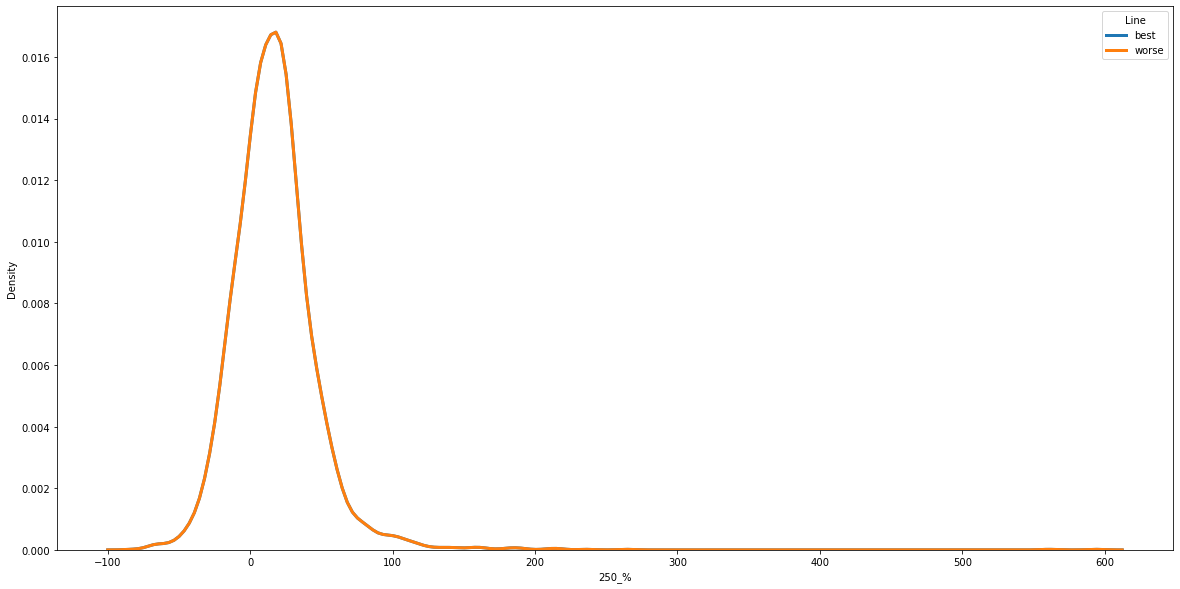

In [ ]:
plt.figure(figsize = (20, 10))
# plt.xlim(-100,100)
sns.distplot(b, hist = False, kde = True, 
                 kde_kws = {'linewidth': 3},
                 label = 'best'
            )
sns.distplot(w, hist = False, kde = True, 
                 kde_kws = {'linewidth': 3},
                 label = 'worse'
            )
plt.legend(prop={'size': 10}, title = 'Line')



In [ ]:

# plt.figure(figsize = (20, 10))
# plt.plot(plot_df['fear'])

# Парсер работает слабо через заголовок

In [ ]:
%%time
# index = 0
# year = data[index]

text_object_dic[CIK] = {}  # тут нельяз перезаписывать
display(CIK)
# for index in range(len(htm_list[CIK][0])):
for index in [0]:   
    display(htm_list[CIK][1][index])
 ##   directory_7item[param_dict['CIK']][data[index]] = {}
    # grab the response
    response = requests.get(htm_list[CIK][0][index].replace('ix?doc=', ''))
    # pass it through the parser, in this case let's just use lxml because the tags seem to follow xml.
    soup = BeautifulSoup(response.content, 'lxml')
    
    page_text = soup.html.body.get_text(' ',strip = True)
    # normalize the text, remove messy characters. Additionally, restore missing window characters.
    page_text_norm = restore_windows_1252_characters(unicodedata.normalize('NFKD', page_text)) 
    # Additional cleaning steps, removing double spaces, and new line breaks.
    page_text_norm = page_text_norm.replace('  ', ' ').replace('\n',' ').replace('''''', '').replace('"', '').replace("'", '').replace("’", '')
    
    #СОЗДАЕМ ТЕКСТ 7
    str1 = page_text_norm[:].lower().rfind('Item 7. managements discussion and analysis of financial condition and results of operation')
    # str1 
    str2 = page_text_norm[:].lower().rfind('item 8. financial statements and supplementary data')
    # str2 
    text_7 = page_text_norm[str1:str2]
    
    if len(text_7) != 0:
#         
        display(len(text_7))
        #Считаем словечки
        text_object = NRCLex(text_7).affect_frequencies
        #Записали в словарь
        
        year = htm_list[CIK][1][index]
        text_object_dic[CIK][year] = {}
#         text_object_dic[CIK][year]['affect_frequencies'] = {}
        text_object_dic[CIK][year]['affect_frequencies'] = NRCLex(text_7).affect_frequencies
        text_object_dic[CIK][year]['text_7'] = text_7
    else:
        display('no data')
        continue
    
    display("количество слов в документе: {}".format(len(text_object_dic[CIK][year]['text_7'])))
display(text_object_dic[CIK].keys())


'0001018724'

'2020-01-31'

'no data'

dict_keys([])

Wall time: 1.53 s
